# Прогнозирование температуры звезды

Обычно для расчёта температуры учёные пользуются следующими методами:

- Закон смещения Вина.
- Закон Стефана-Больцмана.
- Спектральный анализ.

Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.

В базе обсерватории есть характеристики уже изученных 240 звёзд.

**Характеристики**

- Относительная светимость `L/Lo` — светимость звезды относительно Солнца.
- Относительный радиус `R/Ro` — радиус звезды относительно радиуса Солнца.
- Абсолютная звёздная величина `Mv` — физическая величина, характеризующая блеск звезды.
- Звёздный цвет (`white`, `red`, `blue`, `yellow`, `yellow-orange` и др.) — цвет звезды, который определяют на основе спектрального анализа.
- Тип звезды.

|Тип звезды	                         | Номер, соответствующий типу|
|------------------------------------|----------------------------|
|Коричневый карлик	                 | 0                          |
|Красный карлик	                     | 1                          |
|Белый карлик	                     | 2                          |
|Звёзды главной последовательности	 | 3                          |
|Сверхгигант	                     | 4                          |
|Гипергигант	                     | 5                          |

- Абсолютная температура `T(K)` — температура на поверхности звезды в Кельвинах.

Необходимо разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.


**План работы**

1. Загрузка исходных данных из файла.
2. Исследовательский анализ.
3. Подготовка данных к построению модели
4. Построение простой модели нейронной сети — baseline
5. Улучшение сети
6. Выводы по проекту.

Метрика `RMSE` не должна превышать 4500.

## Загрузка данных

**Импорт необходимых для работы библиотек.**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

from math import ceil

import warnings

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 300)

RANDOM = 1234
np.random.seed(RANDOM)
torch.manual_seed(RANDOM)
torch.use_deterministic_algorithms(True)

**Загрузка датасета.**

In [2]:
try:
    data = pd.read_csv("/datasets/6_class.csv")
except FileNotFoundError:
    data = pd.read_csv("https://code.s3.yandex.net/datasets/6_class.csv")

**Проверка загрузки датасета.**

In [3]:
print("Первые пять строк датасета:")

display(data.head())

Первые пять строк датасета:


,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red


**Данные загружены.**

## Предобработка и анализ данных

**Имена столбцов в `snake_case`**

Имена столбцов приведены в произвольной форме. Приведем их к змеиному стилю.
Помимо этого можно удалить столбец `Unnamed: 0` - он не нужен в дольнейшей работе.

In [4]:
data.rename(columns={
    'Temperature (K)': 'temperature',
    'Luminosity(L/Lo)': 'luminosity',
    'Radius(R/Ro)': 'radius',
    'Absolute magnitude(Mv)': 'absolute_magnitude',
    'Star type': 'star_type',
    'Star color': 'star_color'
},
            inplace=True)

data = data.drop(['Unnamed: 0'], axis=1)

**Информация по датафрейму.**

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   temperature         240 non-null    int64  
 1   luminosity          240 non-null    float64
 2   radius              240 non-null    float64
 3   absolute_magnitude  240 non-null    float64
 4   star_type           240 non-null    int64  
 5   star_color          240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 11.4+ KB


In [6]:
print(f"Пропуски в данных:\n")

print(data.isna().sum())

Пропуски в данных:

temperature           0
luminosity            0
radius                0
absolute_magnitude    0
star_type             0
star_color            0
dtype: int64


Пропусков в данных нету. 

В датафрейме есть два типа признаков:

- категориальные: `star_type`, `star_ color`;
- количественные: `luminosity`, `radius`, `absolute_magnitude`.

Целевой признак: `temperature`.

**Анализ категориальных признаков.**

Столбец `star_ color`.

In [7]:
print(f"Уникальные значения:\n")

print(data['star_color'].unique())

Уникальные значения:

['Red' 'Blue White' 'White' 'Yellowish White' 'Blue white'
 'Pale yellow orange' 'Blue' 'Blue-white' 'Whitish' 'yellow-white'
 'Orange' 'White-Yellow' 'white' 'Blue ' 'yellowish' 'Yellowish'
 'Orange-Red' 'Blue white ' 'Blue-White']


Имеются неявные дубликаты в цветах звезд. 
Необходимо унифицировать эти цвета.

<img src="https://kosmosgid.ru/wp-content/uploads/2020/11/Garvardskaya-sovremennaya-spektralnaya-klassifikatsiya-1.jpg">

Унифицировать можно согласно табличке найденной в открытых источниках.

Но нижний порог температуры тут 2000K 

Для этой температуры есть свой цвет:

<img src="https://fsd.multiurok.ru/html/2021/11/04/s_6183aa8b46a39/php9qE8mt_zadanie-24-EGE-astronomiya-1_html_98dd36674ce46cd.jpg">


Поэтому можно унифицировать цвета согласно этим классификациям по истинному цвету.

In [8]:
def change_color(x):
    if x > 30000:
        return 'blue'
    elif 10000 < x <= 30000:
        return 'white_blue'
    elif 7500 < x <= 10000:
        return 'white'
    elif 6000 < x <= 7500:
        return 'yellow_white'
    elif 5000 < x <= 6000:
        return 'yellow'
    elif 3500 < x <= 5000:
        return 'orange'
    elif 2000 < x <= 3500:
        return 'red'
    else:
        return 'brown'

In [9]:
data['star_color'] = data['temperature'].apply(change_color)

In [10]:
print(data['star_color'].unique())

['red' 'brown' 'orange' 'white_blue' 'white' 'yellow_white' 'blue'
 'yellow']


In [11]:
print(data['star_color'].value_counts())

white_blue      76
red             75
orange          40
white           21
blue            14
yellow_white     7
yellow           6
brown            1
Name: star_color, dtype: int64


**Визуализация количества звезд по истинному цвету.** 

In [12]:
data_color = data.groupby(
    ['star_color']).size().reset_index(name='total').sort_values(by='total')

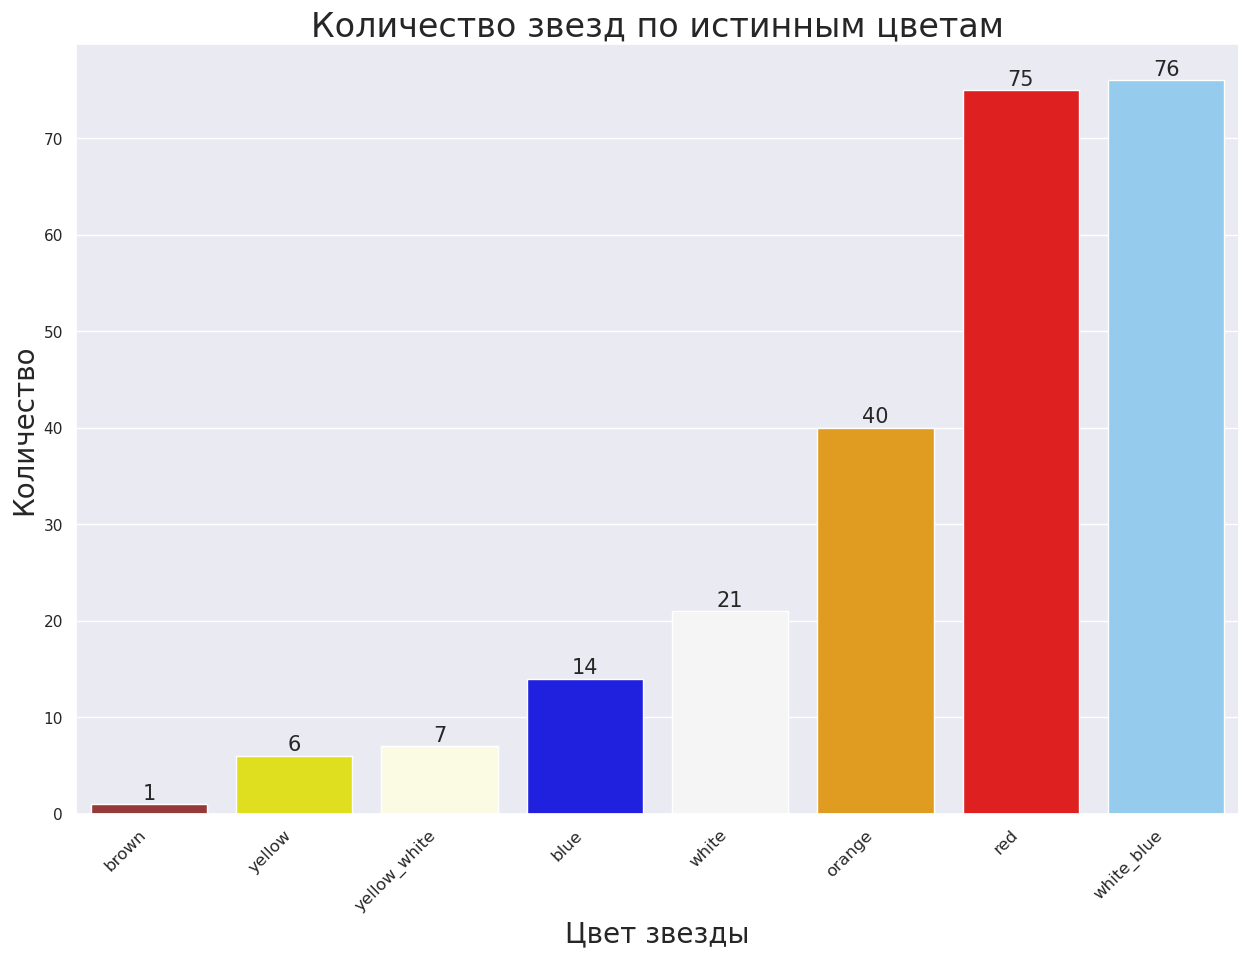

In [13]:
sns.set_theme(style="darkgrid")

cols = [
    'brown', 'yellow', 'lightyellow', 'blue', 'whitesmoke', 'orange', 'red',
    'lightskyblue'
]

fig = plt.subplots(figsize=(15, 10))
ax = sns.barplot(data=data_color,
                 x=data_color['star_color'],
                 y=data_color['total'],
                 palette=cols)
ax.set_xticklabels(labels=data_color['star_color'],
                   rotation=45,
                   ha='right',
                   fontsize=12)

for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.0f'),
                (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                ha='center',
                va='center',
                size=15,
                xytext=(0, 8),
                textcoords='offset points')

ax.set_title("Количество звезд по истинным цветам", fontsize=24)
ax.set_xlabel("Цвет звезды", fontsize=20)
ax.set_ylabel("Количество", fontsize=20)
plt.show()

Столбец `star_type`.

Построим диаграмму для наглядности

In [14]:
data_type = data.groupby(
    ['star_type']).size().reset_index(name='total').sort_values(by='total')

# Создаем словать для перекодировки типов в текстовое значение
labels_dict = {
    0: 'Коричневый карлик',
    1: 'Красный карлик',
    2: 'Белый карлик',
    3: 'Звёзды главной последовательности',
    4: 'Сверхгигант',
    5: 'Гипергигант'
}
# Возвращаем типам звезд текстовое значение
data_type['star_type'] = data_type['star_type'].map(labels_dict)

# Список значений типов звезд для диаграммы
labels_list = data_type['star_type'].tolist()

# Список типов звезд для диаграммы
pie_list = data_type['total'].tolist()

# Цвета
colors = ("orange", "cyan", "brown", "yellow", "green", "red")

# Окантовка кусков диаграммы
wp = {'linewidth': 2, 'edgecolor': "black"}

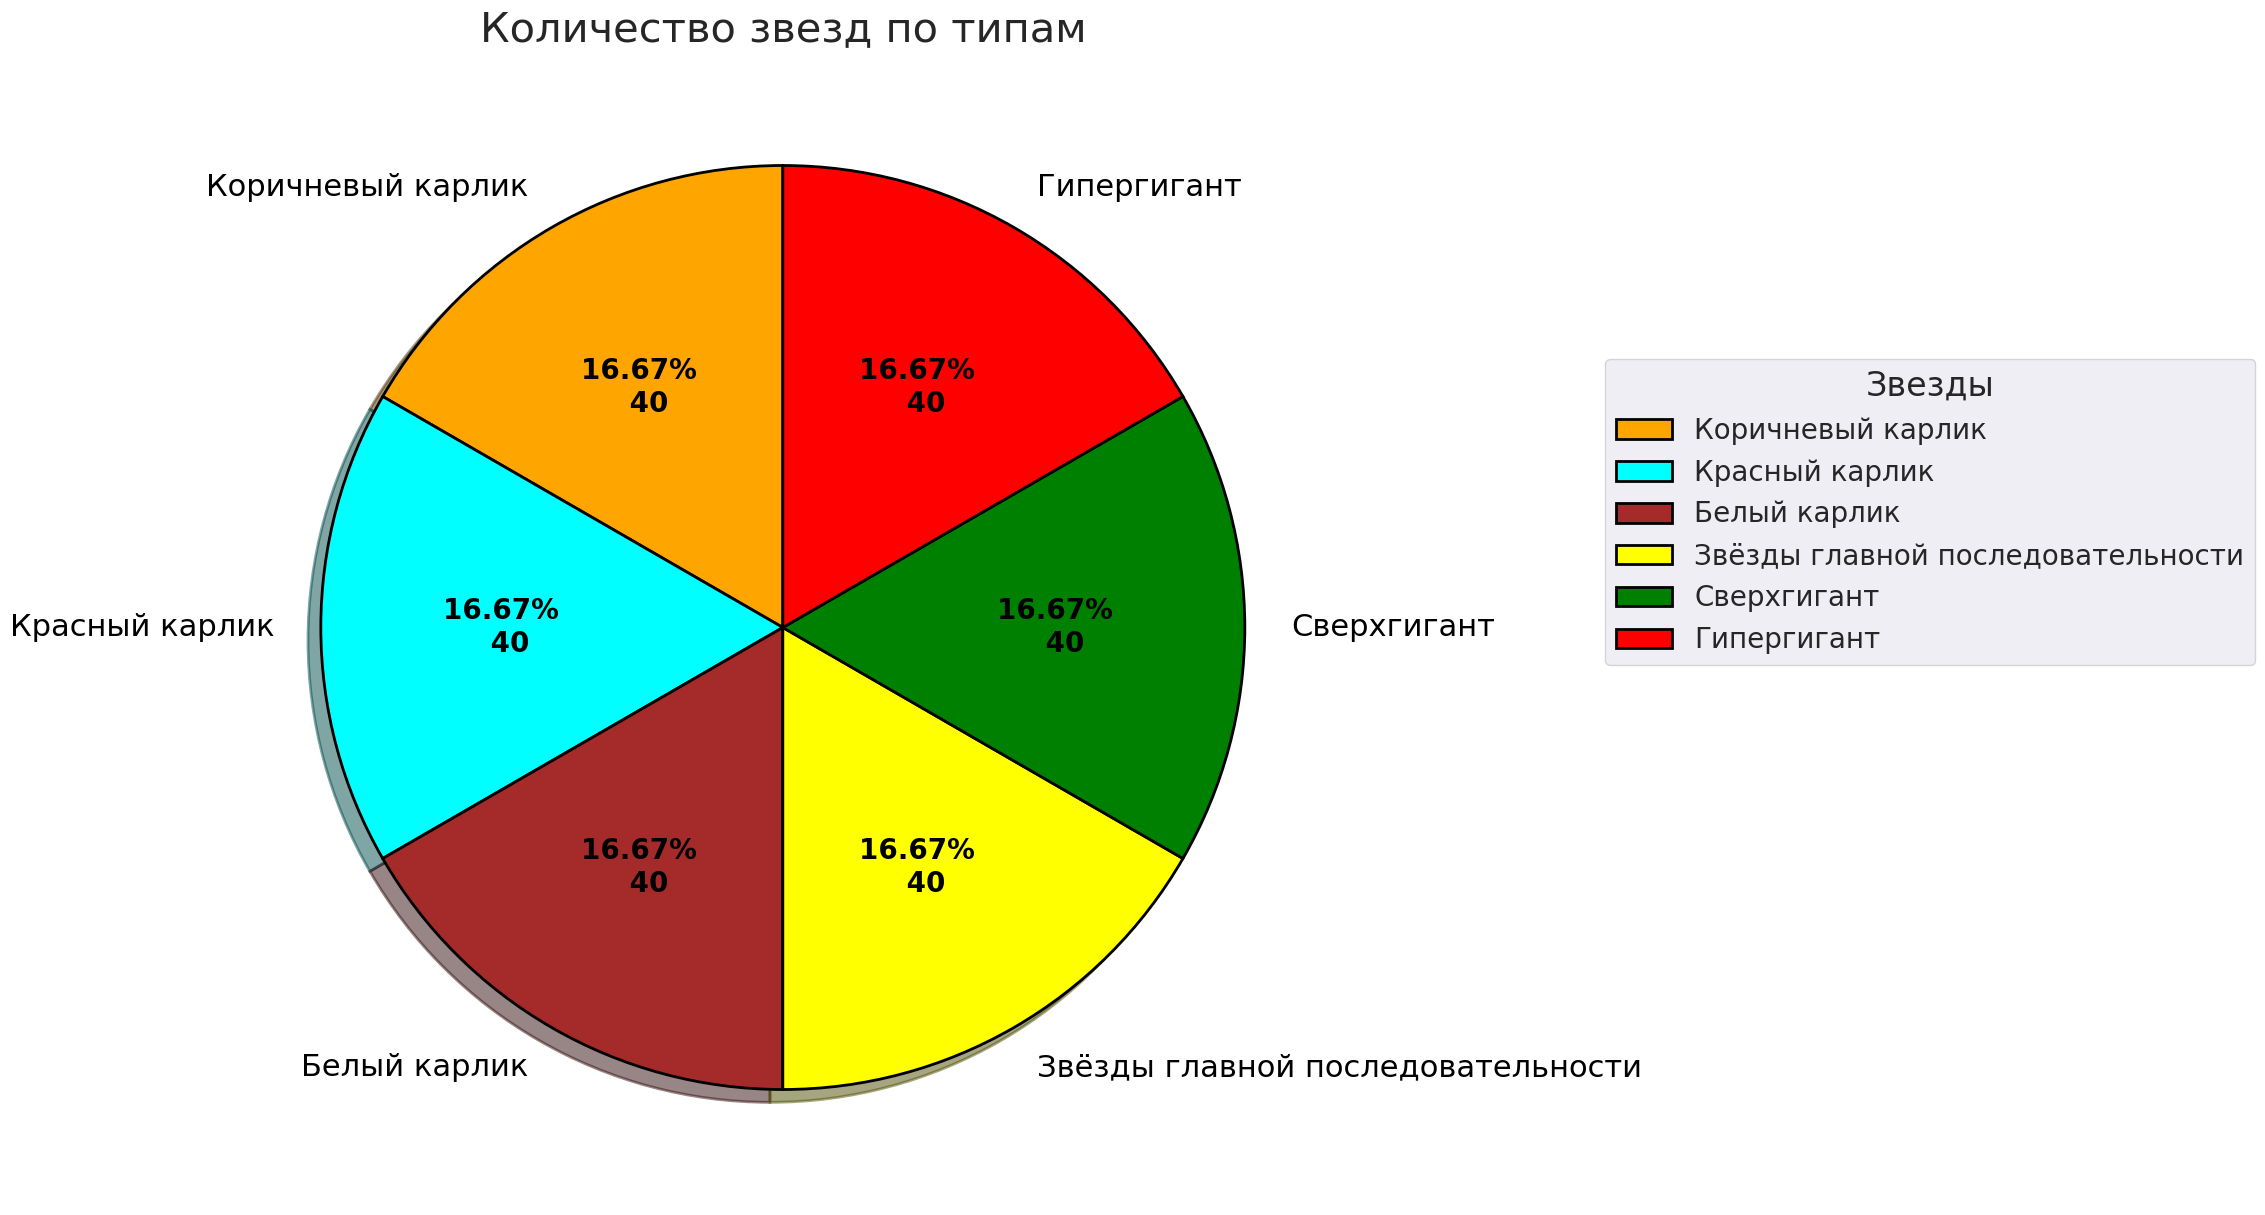

In [15]:
sns.set(font_scale=2)

fig, ax = plt.subplots(figsize=(20, 15))

wedges, texts, autotexts = ax.pie(
    pie_list,
    autopct=lambda p: '{:.2f}% \n {:.0f}'.format(p,
                                                 p * sum(pie_list) / 100),
    labels=labels_list,
    shadow=True,
    colors=colors,
    startangle=90,
    wedgeprops=wp,
    textprops=dict(color="black"))

ax.legend(wedges,
          labels_list,
          title="Звезды",
          loc="center left",
          fontsize=20,
          bbox_to_anchor=(1.2, 0, 0, 1.2))

plt.setp(autotexts, size=20, weight="bold")

ax.set_title("Количество звезд по типам", fontsize=30)

plt.show()

Есть 6 типов звезд в датафрейме:

|Тип звезды	                         | Номер, соответствующий типу|
|------------------------------------|----------------------------|
|Коричневый карлик	                 | 0                          |
|Красный карлик	                     | 1                          |
|Белый карлик	                     | 2                          |
|Звёзды главной последовательности	 | 3                          |
|Сверхгигант	                     | 4                          |
|Гипергигант	                     | 5                          |


Классификации есть разные. Могут классифицироваться в зависимости от массы или радиуса солнца.

Тут скорее всего классифицирована от радиуса. 

Оставим классификацию как есть.

**Перевод категориальных переменных в соответствующий тип.**

In [16]:
data[['star_color', 'star_type']] = data[['star_color',
                                          'star_type']].astype('category')

**Анализ количественных признаков.**

In [17]:
#функции для вывода гистограммы и диаграммы размаха


def histogram(column):
    plt.figure(figsize=(15, 10))
    plt.title('Гистограмма')
    sns.histplot(data=data, x=column, color='navy', kde=True)
    plt.show()


def box(column):
    plt.figure(figsize=(10, 5))
    plt.title('Диаграмма размаха')
    sns.boxplot(x=column, color='g', data=data, orient='h', fliersize=6)
    plt.show()

Столбец `luminosity`.

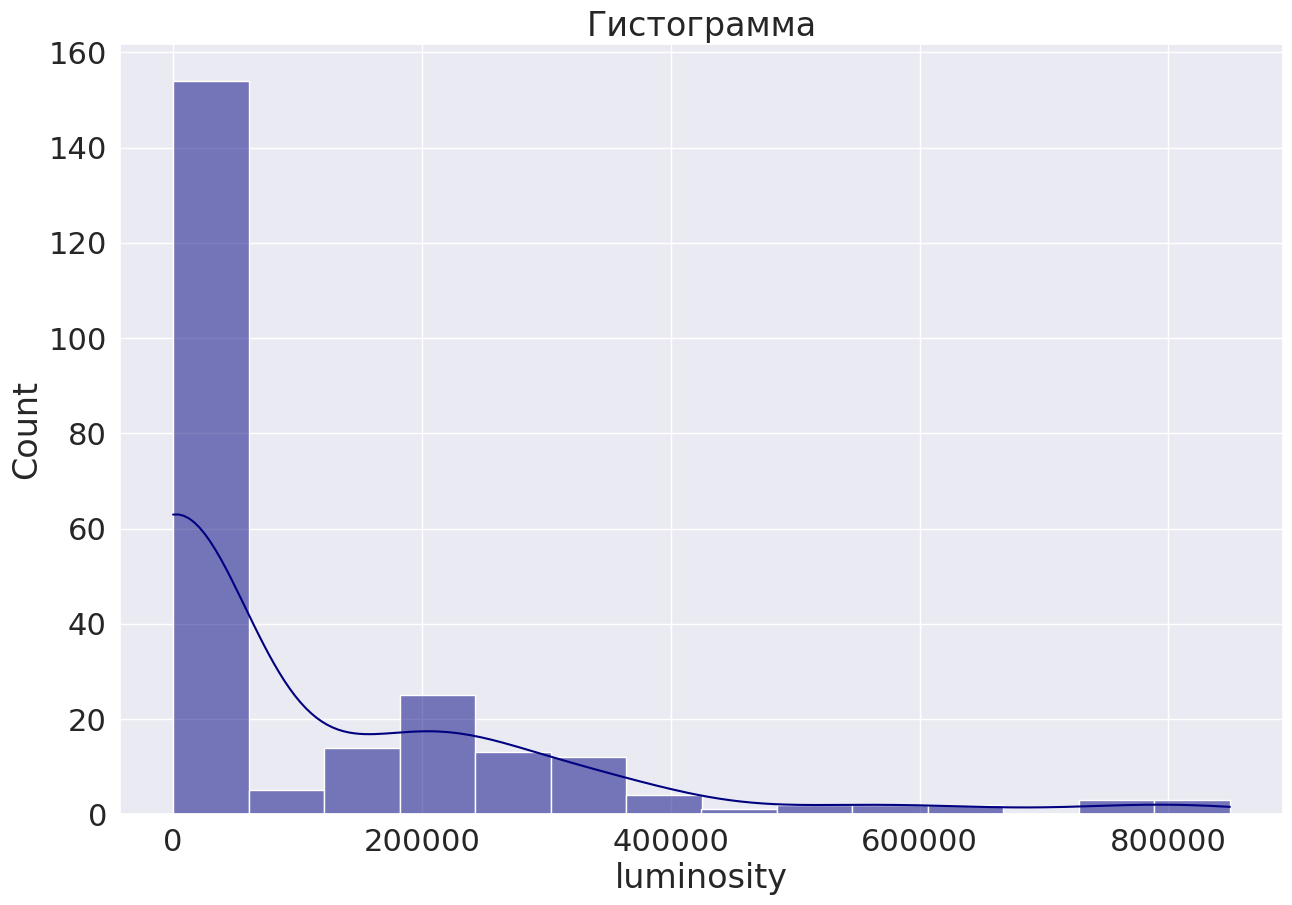

In [18]:
histogram('luminosity')

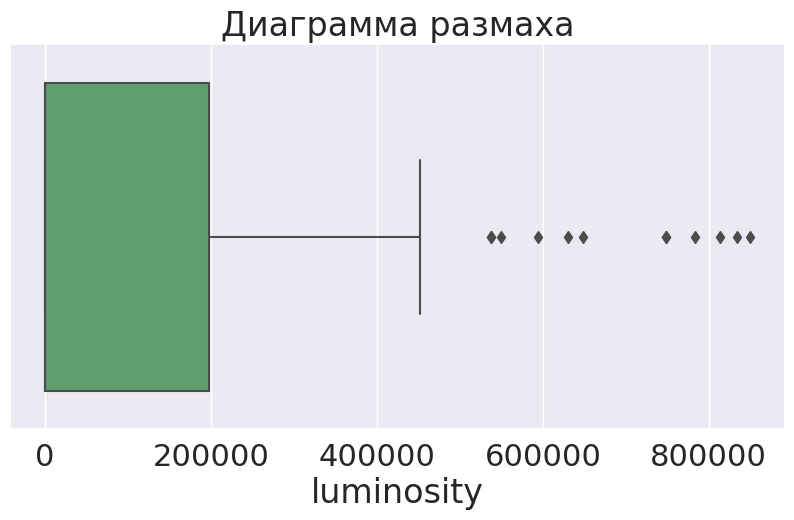

In [19]:
box('luminosity')

In [20]:
data['luminosity'].describe()

count       240.000000
mean     107188.361635
std      179432.244940
min           0.000080
25%           0.000865
50%           0.070500
75%      198050.000000
max      849420.000000
Name: luminosity, dtype: float64

Столбец `radius`.

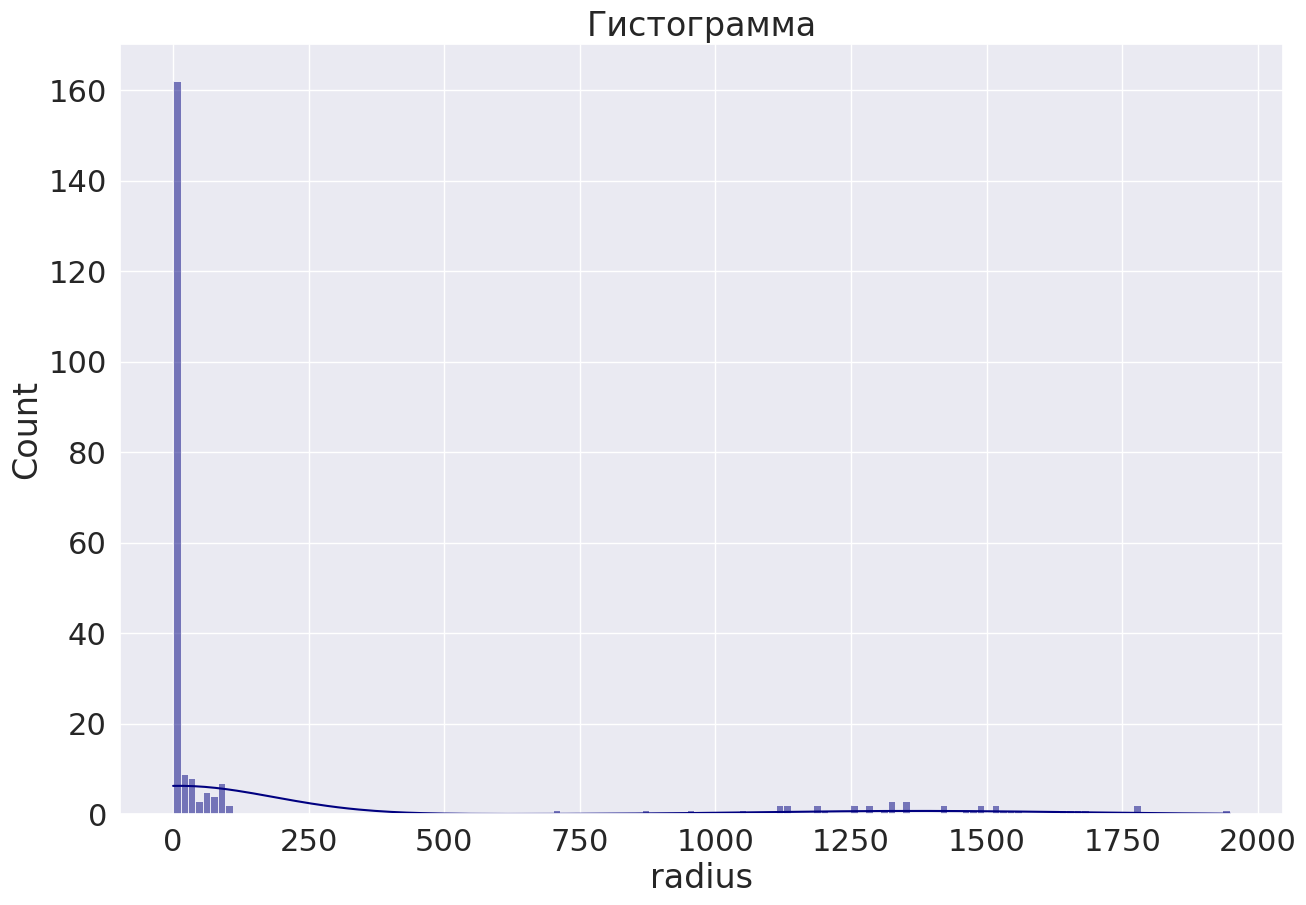

In [21]:
histogram('radius')

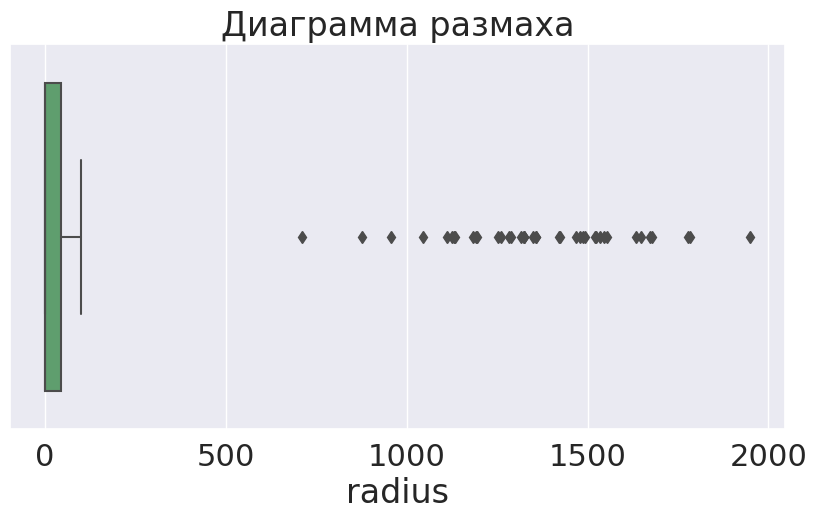

In [22]:
box('radius')

In [23]:
data['radius'].describe()

count     240.000000
mean      237.157781
std       517.155763
min         0.008400
25%         0.102750
50%         0.762500
75%        42.750000
max      1948.500000
Name: radius, dtype: float64

Столбец `absolute_magnitude`.

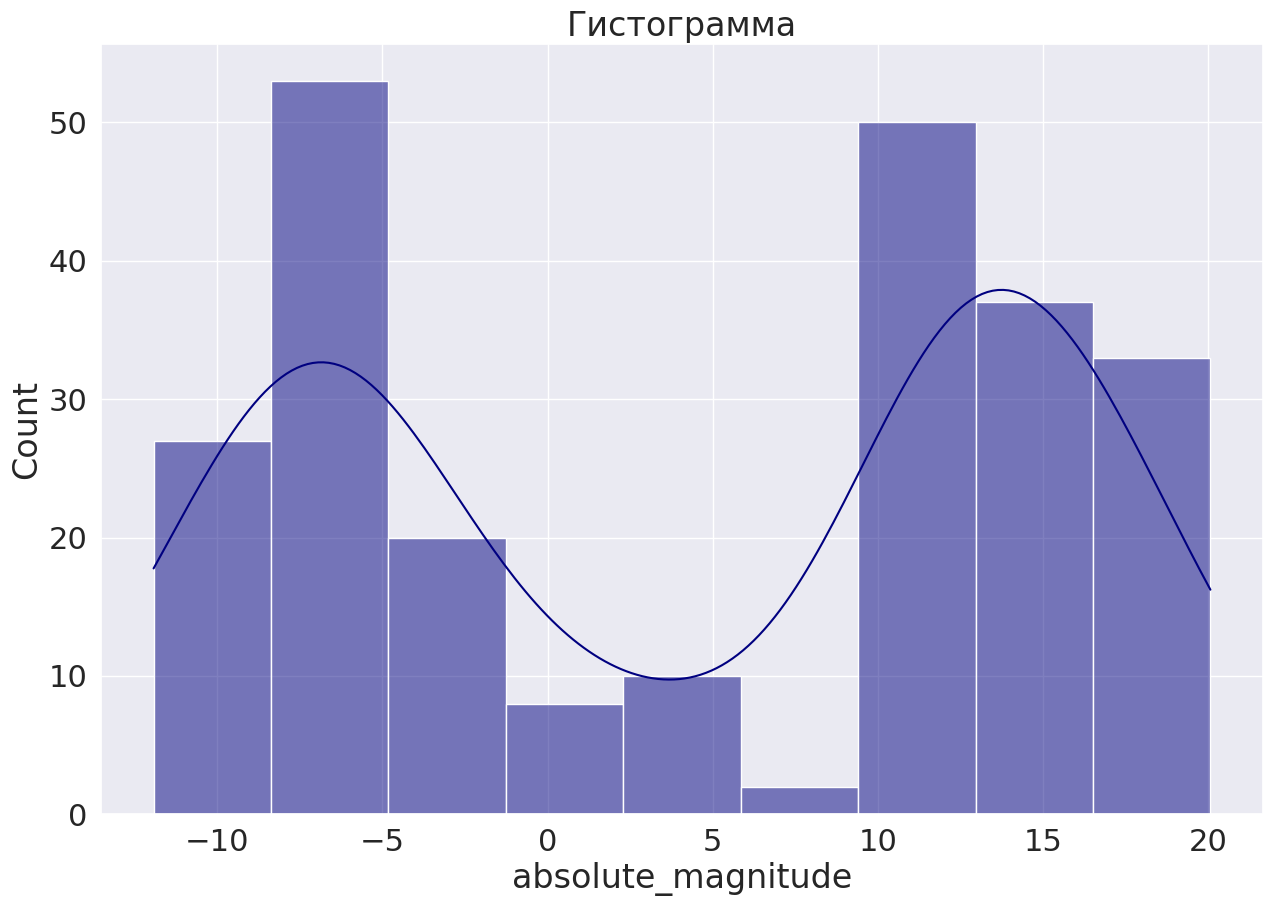

In [24]:
histogram('absolute_magnitude')

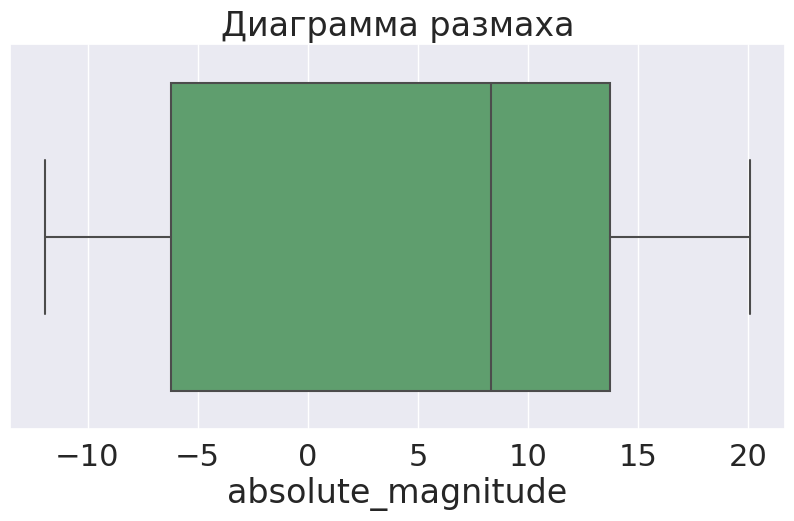

In [25]:
box('absolute_magnitude')

In [26]:
data['absolute_magnitude'].describe()

count    240.000000
mean       4.382396
std       10.532512
min      -11.920000
25%       -6.232500
50%        8.313000
75%       13.697500
max       20.060000
Name: absolute_magnitude, dtype: float64

Во всех признаках: `luminosity`, `radius`, `absolute_magnitude` есть выбросы. 

Но так как задача это астрономия и возможны любые значения, то оставляем как есть.

**Корреляция целевого и остальных количественных признаков.**

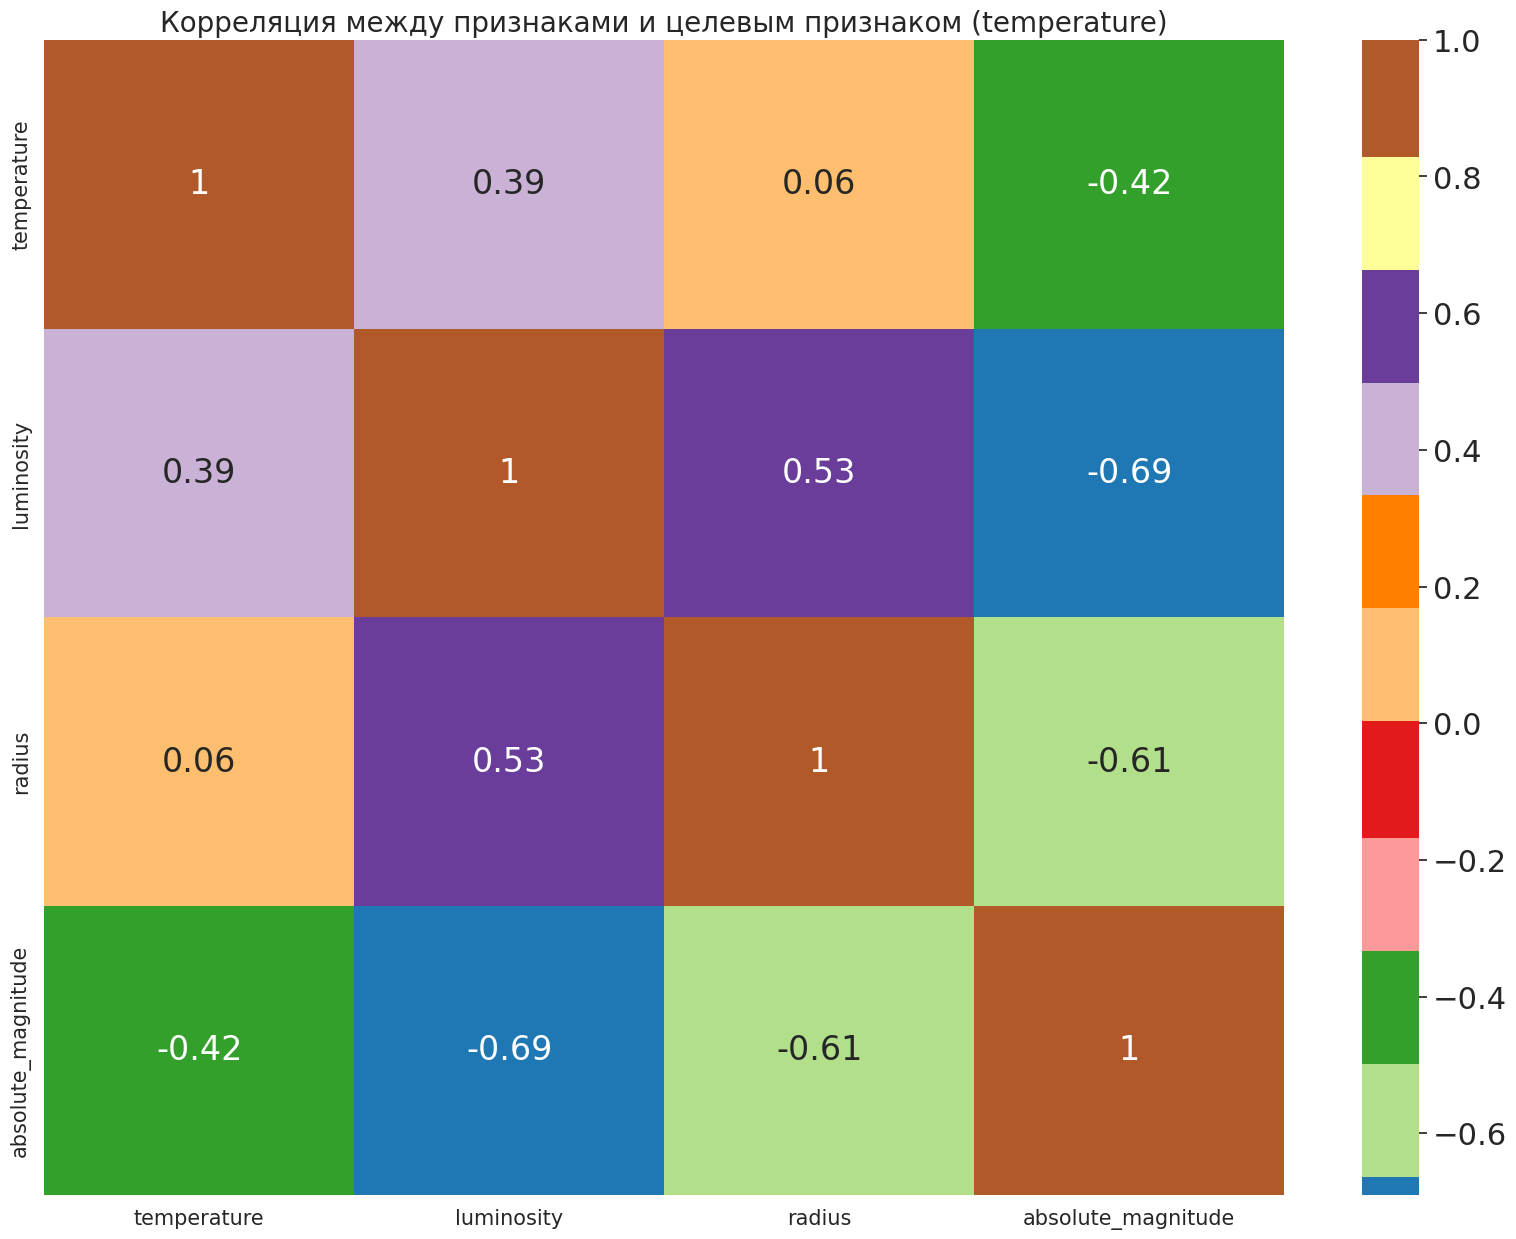

In [27]:
corr_matrix = data.drop(['star_color', 'star_type'], axis=1).corr().round(2)
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, cmap='Paired', center=0, annot=True)
plt.title('Корреляция между признаками и целевым признаком (temperature)',
          fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

Сильной корреляции между целевым и остальными признаками нету.

**Вывод**

В результате предобработки и анализа данных выполнено следующее:

- удалён лишний столбец Unnamed: 0;
- имена столбцов приведены в snake_case;
- устранены неявные дубликаты в цветах звезд. Необходимо унифицировать эти цвета.;
- цвета унифицированы согласно классификациям по истинному цвету;

Количество звезд по типам одинаковое - по 40 штук.

По истинным цветам: 

- white_blue - 76
- red - 75
- orange - 40
- white - 21
- blue - 14
- yellow_white - 7
- yellow - 6
- brown - 1

В данных присутсвуют выбросы, но эти выбросы это просто характеристики звезд.

## Подготовка данных к построению модели

**Разбиение датасета на выборки**.

Исходный датасет разделяем на тренировочную, валидационную и тестовую выборки в соотношении 70:15:15.

In [28]:
features = data.drop(['temperature'], axis=1)
target = data['temperature']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=.3, random_state=RANDOM, shuffle=True)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_test,
    target_test,
    test_size=.5,
    random_state=RANDOM,
    shuffle=True)

print('Тренировочная выборка: ', features_train.shape, target_train.shape)
print('Валидационная выборка: ', features_valid.shape, target_valid.shape)
print('Тестовая выборка: ', features_test.shape, target_test.shape)

Тренировочная выборка:  (168, 5) (168,)
Валидационная выборка:  (36, 5) (36,)
Тестовая выборка:  (36, 5) (36,)


**Масштабирование признаков.**

- категориальные признаки преобразовываются при помощи `OneHotEncoder`;
- количественные признаки преобразовываются при помощи `MinMaxScaler`.

Все это делается с использованием `ColumnTransformer`.

In [29]:
numerics = ['luminosity', 'radius', 'absolute_magnitude']
categorical = ['star_type', 'star_color']

col_transformer = ColumnTransformer(transformers=[
    ('scaler', MinMaxScaler(), numerics),
    ('ohe', OneHotEncoder(sparse=False), categorical)
],
                                    remainder="passthrough")

col_transformer.fit(features)
features_train = col_transformer.transform(features_train)
features_valid = col_transformer.transform(features_valid)
features_test = col_transformer.transform(features_test)

**Создание тензоров по каждой выборке.**

In [30]:
features_train = torch.FloatTensor(np.array(features_train))
features_valid = torch.FloatTensor(np.array(features_valid))
features_test = torch.FloatTensor(np.array(features_test))
target_train = torch.FloatTensor(np.array(target_train))
target_valid = torch.FloatTensor(np.array(target_valid))
target_test = torch.FloatTensor(np.array(target_test))

**Данные подготовлены для построения модели и обучения.**

## Построение базовой нейронной сети

**Определение количества нейронов.**

In [31]:
# Входные нейроны
n_in_neurons = features_train.shape[1]
# Нейроны 1-го скрытого слоя
n_hidden_neurons_1 = n_in_neurons * 2
# Нейроны 2-го скрытого слоя
n_hidden_neurons_2 = n_hidden_neurons_1 // 2
# Нейроны 3-го скрытого слоя
n_hidden_neurons_3 = n_hidden_neurons_2 // 2
# Нейрон на выходе
n_out_neurons = 1

**Списки с количеством нейронов для создания модели.**

In [32]:
# список для одного скрытого слоя
n_neurons_1_hidden = [n_in_neurons, n_hidden_neurons_1, n_out_neurons]

# список для двух скрытых слоев
n_neurons_2_hidden = [
    n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons
]

# список для трех скрытых слоев
n_neurons_3_hidden = [
    n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3,
    n_out_neurons
]

**Функция для создания моделей.**

In [33]:
def create_model(neurons_list, drop=False, batch_norm=False, info=True, p_1=0, p_2=0):
    '''
    Функция создает модель для обучения нейронной сети.
    
    neurons_list: список с количеством нейронов для слоев нейросети
    drop: параметр, определяющий нужен ли dropout, по умолчанию False
    batch_norm: параметр, определяющий нужен ли BatchNorm, по умолчанию False
    info: параметр, определяющий нужен ли вывод информации по созданной модели, по умолчанию True
    p_1: параметр dropout для нечётного слоя, по умолчанию 0
    p_2: параметр dropout для чётного слоя, по умолчанию 0
    
    '''
    net_layers = []

    # создание базовой модели без dropout и BatchNorm
    if not drop and not batch_norm:

        for i in range(1, len(neurons_list) - 1):

            # добавляется полносвязный слой
            net_layers.append(nn.Linear(neurons_list[i - 1], neurons_list[i]))
            # добавляется функция активации
            net_layers.append(nn.ReLU())

        # добавляется выходной слой
        net_layers.append(nn.Linear(neurons_list[-2], neurons_list[-1]))
        # добавляется функция активации в выходной слой
        net_layers.append(nn.ReLU())
        # модель на выходе
        net = nn.Sequential(*net_layers)

    # создание модели без dropout, но с BatchNorm
    elif batch_norm and not drop:

        for i in range(1, len(neurons_list) - 1):

            # добавляется полносвязный слой
            net_layers.append(nn.Linear(neurons_list[i - 1], neurons_list[i]))
            # добавляется BatchNorm1d
            net_layers.append(nn.BatchNorm1d(neurons_list[i]))
            # добавляется функция активации
            net_layers.append(nn.ReLU())

        # добавляется выходной слой
        net_layers.append(nn.Linear(neurons_list[-2], neurons_list[-1]))
        # добавляется функция активации в выходной слой
        net_layers.append(nn.ReLU())
        # модель на выходе
        net = nn.Sequential(*net_layers)

    # создание модели c dropout без BatchNorm
    elif not batch_norm and drop:

        for i in range(1, len(neurons_list) - 1):

            # добавляется полносвязный слой
            net_layers.append(nn.Linear(neurons_list[i - 1], neurons_list[i]))

            # добавляется Dropout
            if (i + 1) % 2 == 0:
                net_layers.append(nn.Dropout(p=p_2))
            else:
                net_layers.append(nn.Dropout(p=p_1))

            # добавляется функция активации
            net_layers.append(nn.ReLU())

        # добавляется выходной слой
        net_layers.append(nn.Linear(neurons_list[-2], neurons_list[-1]))
        # добавляется функция активации в выходной слой
        net_layers.append(nn.ReLU())
        # модель на выходе
        net = nn.Sequential(*net_layers)

    else:
        print('BatchNorm и DropOut лучше не использовать')

    if info:
        # вывод информацие о модели если потребуется
        print(f'Структура модели: {net}')

    return net

**Функция инициализации весов нейронной сети.**

In [34]:
def init_weights(layer):
    '''
    
    Функция инициализации весов нейронной сети.
    
    '''

    if type(layer) == nn.Linear:  # Проверка, что слой — полносвязный
        nn.init.normal_(layer.weight, mean=0.5, std=1)
        nn.init.normal_(layer.bias, mean=0.5, std=2)

**Базовая модель нейронной сети с одним скрытым слоем.**

In [35]:
base_line = create_model(n_neurons_1_hidden)

Структура модели: Sequential(
  (0): Linear(in_features=17, out_features=34, bias=True)
  (1): ReLU()
  (2): Linear(in_features=34, out_features=1, bias=True)
  (3): ReLU()
)


**Базовая модель нейронной сети с двумя скрытыми слоями.**

In [36]:
base_line_2 = create_model(n_neurons_2_hidden)

Структура модели: Sequential(
  (0): Linear(in_features=17, out_features=34, bias=True)
  (1): ReLU()
  (2): Linear(in_features=34, out_features=17, bias=True)
  (3): ReLU()
  (4): Linear(in_features=17, out_features=1, bias=True)
  (5): ReLU()
)


**Базовая модель нейронной сети с тремя скрытыми слоями.**

In [37]:
base_line_3 = create_model(n_neurons_3_hidden)

Структура модели: Sequential(
  (0): Linear(in_features=17, out_features=34, bias=True)
  (1): ReLU()
  (2): Linear(in_features=34, out_features=17, bias=True)
  (3): ReLU()
  (4): Linear(in_features=17, out_features=8, bias=True)
  (5): ReLU()
  (6): Linear(in_features=8, out_features=1, bias=True)
  (7): ReLU()
)


**Словарь для перебора моделей.**

In [38]:
models_list = {
    '1 скрытый слой': base_line,
    '2 скрытых слоя': base_line_2,
    '3 скрытых слоя': base_line_3
}

**Определение необходимых параметров для обучения моделей.**

In [39]:
# фунуция потерь
loss_function = nn.MSELoss()

# размеры батча
batch_sizes = [6, 12, 24]

# количество эпох обучения
epochs = 100000

# список коэффициентов сходимости
learning_rate_list = [0.001, 0.01, 0.1]

**Функция для обучения моделей на тренировочной выборке и проверке на валидационной с условием ранней остановки с целью избежать переобучения.**

In [40]:
def train_and_valid(model,
                    epochs,
                    loss_function,
                    features_train,
                    target_train,
                    features_valid,
                    target_valid,
                    rate,
                    batch_size,
                    epoch_step=100):
    '''
    Функция обучает модель на тренировочной выборке и проверяет на валидационной с условием ранней 
    остановки с целью избежать переобучения.
    
    model: модель для обучения
    epochs: количество эпох обучения
    loss_function: функция потерь
    features_train: признаки на тренировочной выборке
    target_train: целевой признак на тренировочной выборке
    features_valid: признаки на валидационной выборке
    target_valid: целевой признак на валидационной выборке
    rate: коэффициент сходимости
    batch_size: размер батча
    epoch_step: шаг для проверки на валидации между эпохами обучения, по умолчанию 100
    
    Функция возвращает метрику rmse и непосредственно модель.
        
    '''

    # инициализация весов модели при помощи ранее объявленной функции init_weights
    model_work = model.apply(init_weights)

    # инициализация оптимизатора для модели, с переданным коэффициентом сходимости rate
    optimizer = torch.optim.Adam(model_work.parameters(), lr=rate)

    # количество батчей
    num_batches = ceil(len(features_train) / batch_size)

    #  изначальное значени ошибки для проверки ранней остановки
    the_last_loss = 1
    # количество значений ошибок при увеличении значении ошибки
    patience = 2
    # счетчик разницы значений метрики ошибок с сторону увеличений
    diff = 0

    # информация какая модель обучается
    print()
    print('Идет обучение модели....\nОбучается модель: ', model_work,
          '\nLearning rate --->', rate, '\nРазмер батча -->', batch_size,
          '\nШаг между эпохами на валидации -->', epoch_step, '\n')
    print()

    for epoch in range(1, epochs + 1):
        # перевод модели в режим обучения
        model.train()
        # случайна перестановка индексов объектов
        order = np.random.permutation(len(features_train))

        for batch_idx in range(num_batches):

            start_index = batch_idx * batch_size  # номер стартового объекта батча
            optimizer.zero_grad()  # обнуление градиентов

            batch_indexes = order[
                start_index:start_index +
                batch_size]  # индексы объектов текущего обатча
            X_batch = features_train[batch_indexes]
            y_batch = target_train[batch_indexes]
            preds = model_work.forward(X_batch).flatten(
            )  # прямое распространение на обучающих данных
            loss_value = loss_function(
                preds, y_batch)  # вычисление значения функции потерь
            loss_value.backward()  # вычисление градиентов
            optimizer.step()  # один шаг оптимизации весов

        if epoch % epoch_step == 0 or epoch == epochs:
            # перевод сети в режим предсказания
            model.eval()
            with torch.no_grad():

                val_preds = model_work.forward(features_valid).flatten(
                )  # прямое распространение на валидации
                loss = torch.sqrt(loss_function(
                    val_preds,
                    target_valid))  # вычисление значения функции потерь

                the_current_loss = loss.item(
                )  # присвоение текущей ошибки в переменныю the_current_loss

                # ннепосредственная проверка на раннюю остановку

                if the_current_loss > the_last_loss:

                    diff += 1

                    if diff >= patience:

                        print(
                            'Ранняя остановка!\nЭпоха № ', epoch,
                            '\nRMSE модели на валидации после ранней остановки: ',
                            the_current_loss)
                        print('\nМодель обучена!')

                        return (model_work, the_current_loss)
                else:
                    diff = 0

                the_last_loss = the_current_loss

    print('Эпохи закончились....')
    print('\nМодель обучена!')

    # возврат модели и метрики на валидации
    return (model_work, the_current_loss)

**Функция получения результатов предсказаний модели и метрики RMSE на тестовой выборке.**

In [41]:
def test(model, features_test, target_test):
    '''
    Функция получения результатов предсказаний модели и метрики RMSE на тестовой выборке..
    
    model: модель для обучения
    features_test: признаки на тестовой выборке
    target_test: целевой признак на тестовой выборке
    
    Функция возвращает метрику rmse и предсказания модели.
        
    '''
    # перевод сети в режим предсказания
    model.eval()
    with torch.no_grad():

        test_preds = model.forward(
            features_test).flatten()  # прямое распространение на тесте
        loss = torch.sqrt(loss_function(
            test_preds, target_test))  # вычисление значения функции потерь

        rmse = loss.item()  # финальная метрика

    # возврат метрики rmse и предсказаний модели.
    return (rmse, test_preds)

**Обучение моделей.**

Ниже будут обучены модели:

- 1 скрытый слой, 
- 2 скрытых слоя,
- 3 скрытых слоя.

Коэффициенты сходимости:
- 0.001, 
- 0.01, 
- 0.1.

Размер батча:
- 6, 
- 12, 
- 24.

In [42]:
# список для добавления результатов
result = []

# перебор моделей
for name, model in models_list.items():
    # перебор коэффициентов
    for rate in learning_rate_list:
        # перебор размеров батча
        for batch in batch_sizes:
            model_out, rmse_valid = train_and_valid(model,
                                                    epochs,
                                                    loss_function,
                                                    features_train,
                                                    target_train,
                                                    features_valid,
                                                    target_valid,
                                                    rate,
                                                    batch,
                                                    epoch_step=100)

            result.append([name, model_out, rate, batch, rmse_valid])


Идет обучение модели....
Обучается модель:  Sequential(
  (0): Linear(in_features=17, out_features=34, bias=True)
  (1): ReLU()
  (2): Linear(in_features=34, out_features=1, bias=True)
  (3): ReLU()
) 
Learning rate ---> 0.001 
Размер батча --> 6 
Шаг между эпохами на валидации --> 100 


Ранняя остановка!
Эпоха №  2200 
RMSE модели на валидации после ранней остановки:  3202.46826171875

Модель обучена!

Идет обучение модели....
Обучается модель:  Sequential(
  (0): Linear(in_features=17, out_features=34, bias=True)
  (1): ReLU()
  (2): Linear(in_features=34, out_features=1, bias=True)
  (3): ReLU()
) 
Learning rate ---> 0.001 
Размер батча --> 12 
Шаг между эпохами на валидации --> 100 


Ранняя остановка!
Эпоха №  3500 
RMSE модели на валидации после ранней остановки:  3193.655517578125

Модель обучена!

Идет обучение модели....
Обучается модель:  Sequential(
  (0): Linear(in_features=17, out_features=34, bias=True)
  (1): ReLU()
  (2): Linear(in_features=34, out_features=1, bias=Tr

**Результирующая таблица.**

In [43]:
cols = ['name', 'model', 'learning_rate', 'batch_size', 'rmse_valid']
result_df = pd.DataFrame(data=result, columns=cols)
result_df

,name,model,learning_rate,batch_size,rmse_valid
0,1 скрытый слой,"[Linear(in_features=17, out_features=34, bias=True), ReLU(), Linear(in_features=34, out_features=1, bias=True), ReLU()]",0.001,6,3202.468262
1,1 скрытый слой,"[Linear(in_features=17, out_features=34, bias=True), ReLU(), Linear(in_features=34, out_features=1, bias=True), ReLU()]",0.001,12,3193.655518
2,1 скрытый слой,"[Linear(in_features=17, out_features=34, bias=True), ReLU(), Linear(in_features=34, out_features=1, bias=True), ReLU()]",0.001,24,3188.704346
3,1 скрытый слой,"[Linear(in_features=17, out_features=34, bias=True), ReLU(), Linear(in_features=34, out_features=1, bias=True), ReLU()]",0.010,6,3199.868164
4,1 скрытый слой,"[Linear(in_features=17, out_features=34, bias=True), ReLU(), Linear(in_features=34, out_features=1, bias=True), ReLU()]",0.010,12,3213.387939
5,1 скрытый слой,"[Linear(in_features=17, out_features=34, bias=True), ReLU(), Linear(in_features=34, out_features=1, bias=True), ReLU()]",0.010,24,3182.687500
6,1 скрытый слой,"[Linear(in_features=17, out_features=34, bias=True), ReLU(), Linear(in_features=34, out_features=1, bias=True), ReLU()]",0.100,6,3517.147949
7,1 скрытый слой,"[Linear(in_features=17, out_features=34, bias=True), ReLU(), Linear(in_features=34, out_features=1, bias=True), ReLU()]",0.100,12,3321.101807
8,1 скрытый слой,"[Linear(in_features=17, out_features=34, bias=True), ReLU(), Linear(in_features=34, out_features=1, bias=True), ReLU()]",0.100,24,3198.158447
9,2 скрытых слоя,"[Linear(in_features=17, out_features=34, bias=True), ReLU(), Linear(in_features=34, out_features=17, bias=True), ReLU(), Linear(in_features=17, out_features=1, bias=True), ReLU()]",0.001,6,3136.016357


**Лучшая базовая модель.**

In [44]:
display(
    result_df.loc[result_df['rmse_valid'] == result_df['rmse_valid'].min()])

,name,model,learning_rate,batch_size,rmse_valid
11,2 скрытых слоя,"[Linear(in_features=17, out_features=34, bias=True), ReLU(), Linear(in_features=34, out_features=17, bias=True), ReLU(), Linear(in_features=17, out_features=1, bias=True), ReLU()]",0.001,24,3117.431396


Лучший результат показала модель с двумя скрытыми слоями и коэффициентом сходимости 0.001, размером батча 24 и RMSE - 3117,43

Для наглядности переобучим лучшую модель и получим метрику на тестовой выборке.

In [45]:
best_model = create_model(n_neurons_2_hidden, info=False)

model_out, _ = train_and_valid(best_model,
                               epochs,
                               loss_function,
                               features_train,
                               target_train,
                               features_valid,
                               target_valid,
                               rate=0.001,
                               batch_size=24,
                               epoch_step=100)

rmse_test, test_preds = test(model_out, features_test, target_test)

print(f'Метрика RMSE на тестовой выборке для лучшей модели ------------>',
      round(rmse_test, 4))


Идет обучение модели....
Обучается модель:  Sequential(
  (0): Linear(in_features=17, out_features=34, bias=True)
  (1): ReLU()
  (2): Linear(in_features=34, out_features=17, bias=True)
  (3): ReLU()
  (4): Linear(in_features=17, out_features=1, bias=True)
  (5): ReLU()
) 
Learning rate ---> 0.001 
Размер батча --> 24 
Шаг между эпохами на валидации --> 100 


Ранняя остановка!
Эпоха №  1100 
RMSE модели на валидации после ранней остановки:  3133.142578125

Модель обучена!
Метрика RMSE на тестовой выборке для лучшей модели ------------> 3402.606


Метрика на тестовой выборке **3402.6064**, что заметно ниже заявленного порога в **4500**.

**Графическая интерпретация фактических и предсказанных значений базовой модели.**

In [46]:
def fact_forecast(test_preds, target_test):
    '''
    Функция визуализирует реальные и предсказанные значения модели на тестовой выборке

    test_preds: предсказанные значения целевого признака
    target_test: реальные значения целевого признака

    '''

    preds = test_preds.detach().numpy().reshape([-1])
    real = target_test.detach().numpy().reshape([-1])
    x = np.arange(len(preds))

    fig, ax = plt.subplots()
    fig.set_figwidth(30)
    fig.set_figheight(20)
    ax.set_xticks(x)
    fact = ax.bar(x, real, width=0.9, label='Факт', color='g')
    forecast = ax.bar(x, preds, width=0.2, label='Прогноз', color='black')
    ax.legend()
    ax.set_title('График "Факт-прогноз"', fontsize=20)
    ax.set_xlabel('Звезда')
    ax.set_ylabel('Температура звезды')
    plt.show()

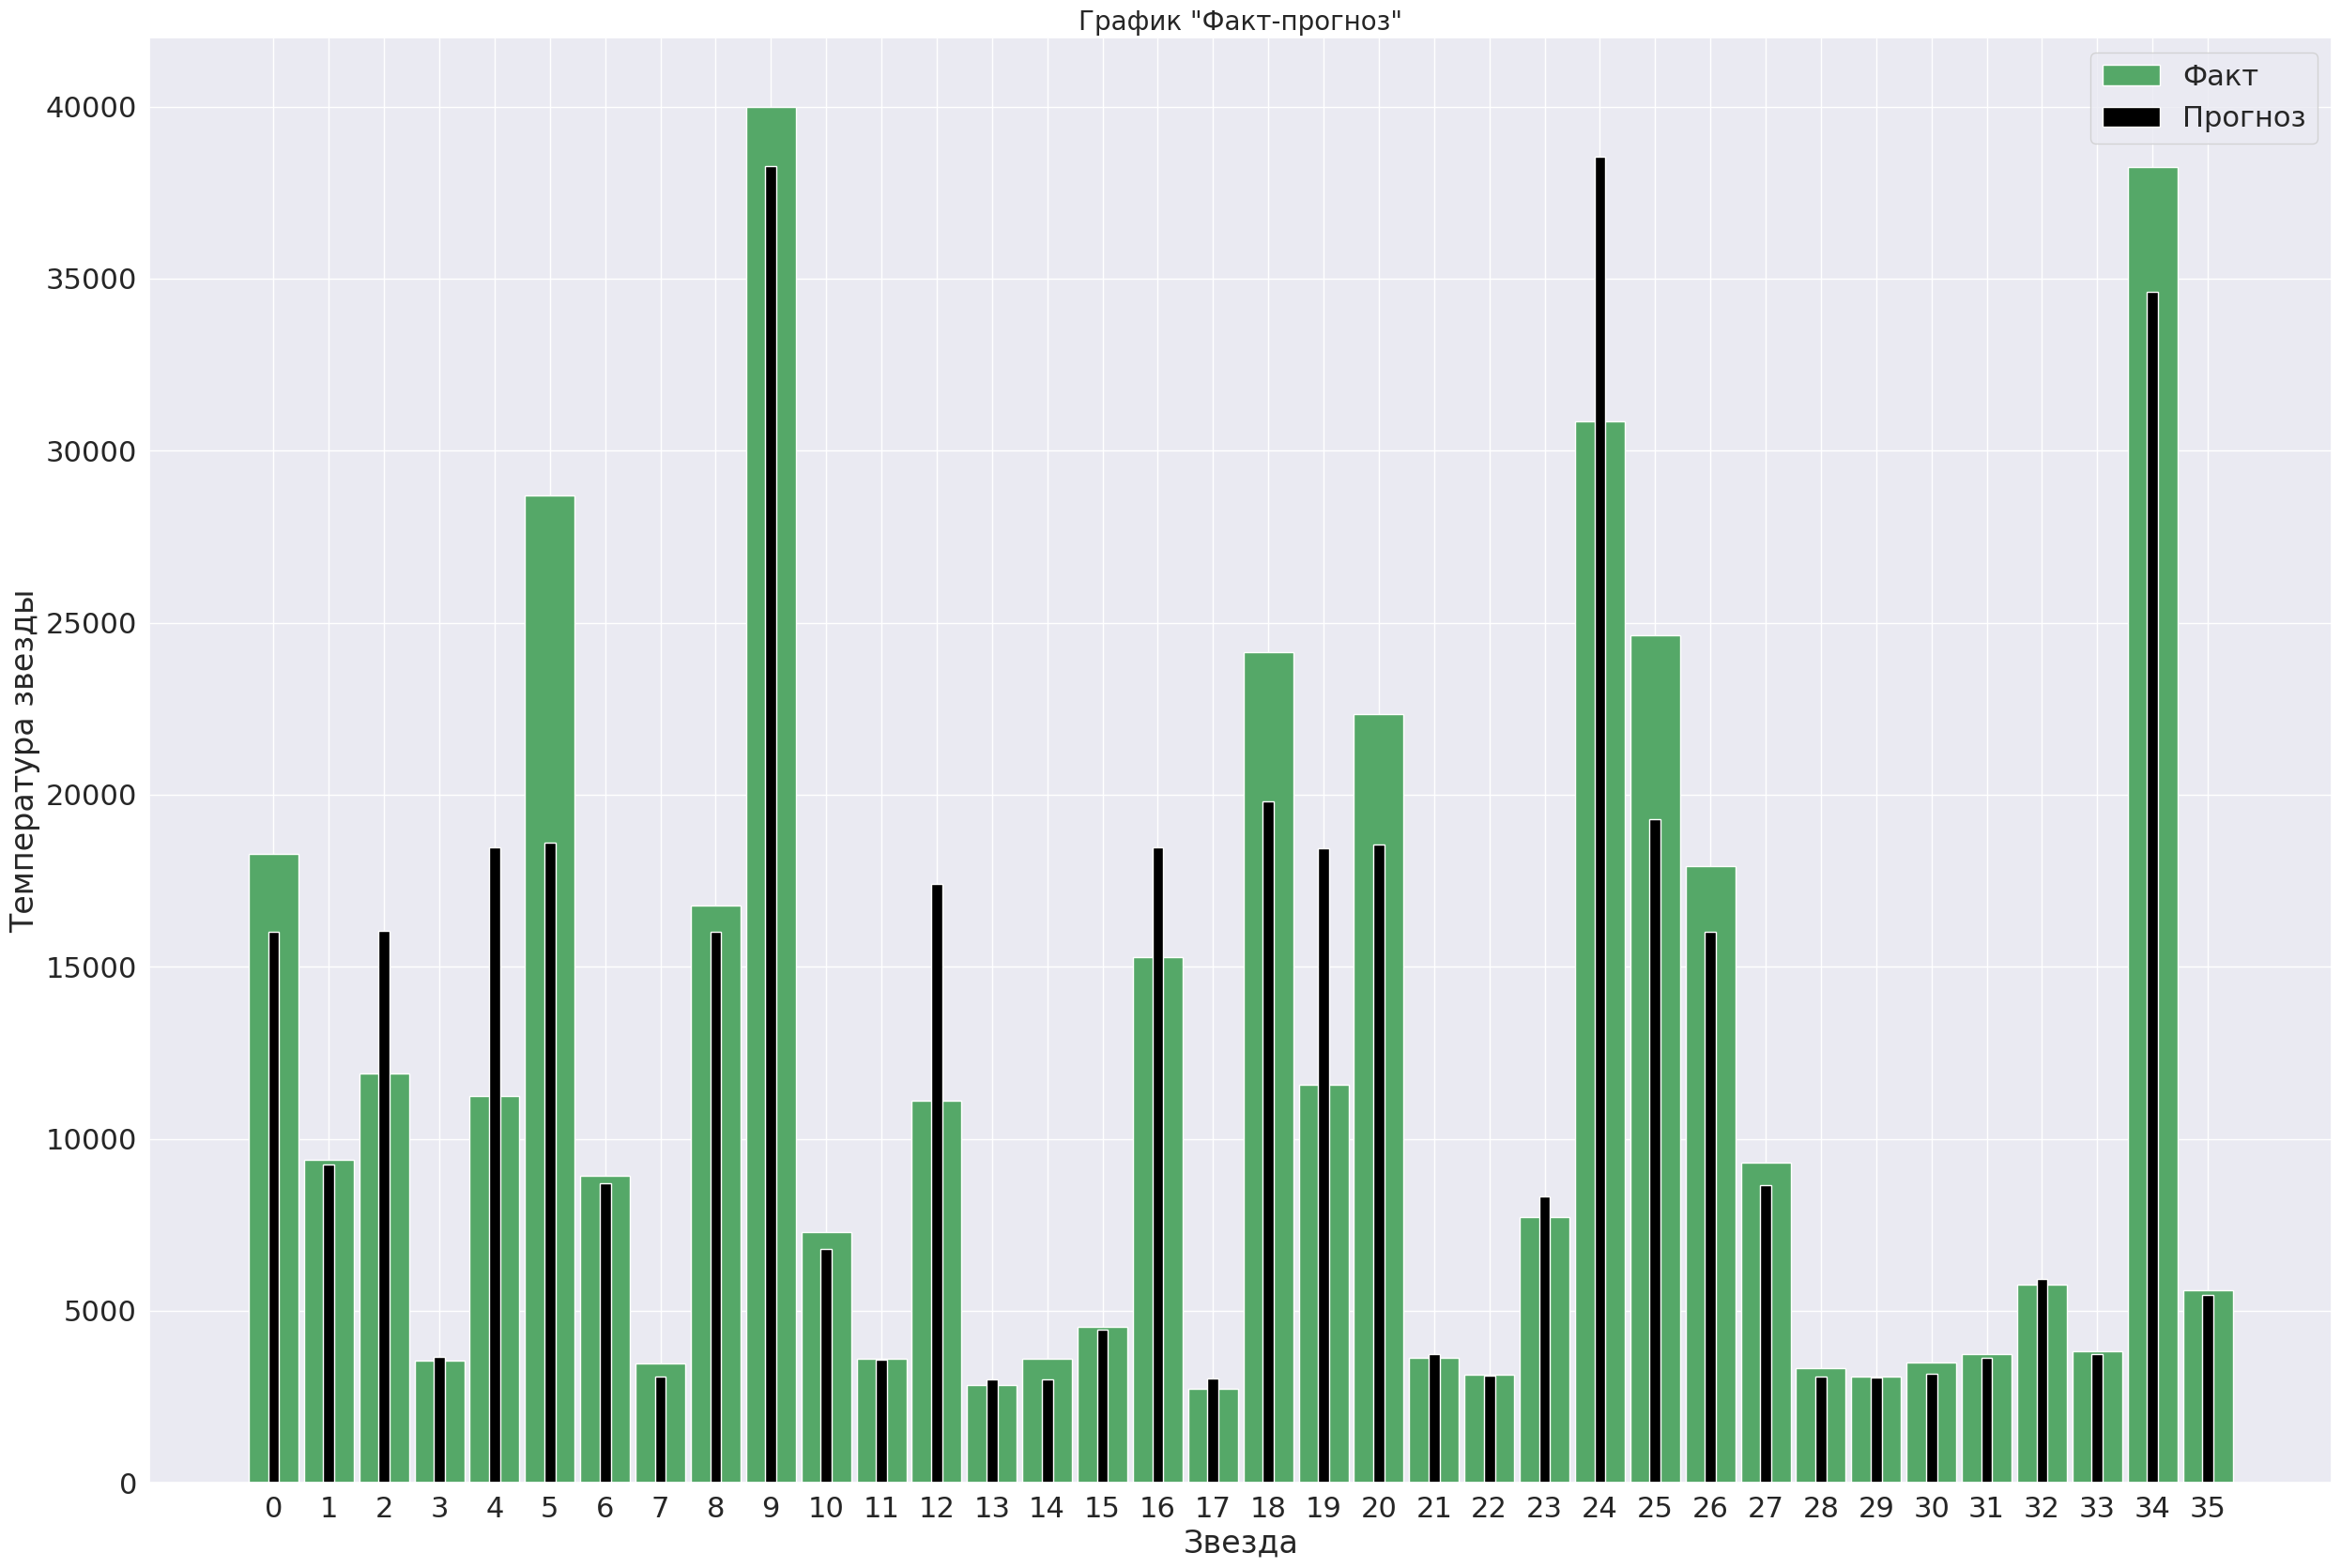

In [47]:
fact_forecast(test_preds, target_test)

**Вывод**

Базовая модель нейронной сети создана.

Необходимый результат метрики **RMSE: 3402.6064** получен уже на базовой модели.

Параметры базовой модели:

- полносвязанная нейронная сеть,
- количество входных нейронов: 17
- нейроны первого слоя: 34,
- нейроны второго слоя: 17,
- 1 выходной нейрон,
- оптимизатор `Adam`,
- коэффициент сходимости: 0.001
- размер батча: 24

Ниже попытаюсь улучшить модель при помощи `BatchNorm` и `DropOut`

## Улучшение нейронной сети

**Создание, обучение и предсказания на модели с `BatchNorm1d`.**

In [48]:
best_model_batch_norm = create_model(n_neurons_2_hidden,
                                     batch_norm=True,
                                     info=False)

model_batch_norm, _ = train_and_valid(best_model_batch_norm,
                                      epochs,
                                      loss_function,
                                      features_train,
                                      target_train,
                                      features_valid,
                                      target_valid,
                                      rate=0.001,
                                      batch_size=24,
                                      epoch_step=100)

rmse_test_bath_norm, test_preds_batch_norm = test(model_batch_norm,
                                                  features_test, target_test)

print(
    f'Метрика RMSE на тестовой выборке для лучшей модели испосльзуя BatchNorm ------------>',
    round(rmse_test_bath_norm, 4))


Идет обучение модели....
Обучается модель:  Sequential(
  (0): Linear(in_features=17, out_features=34, bias=True)
  (1): BatchNorm1d(34, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=34, out_features=17, bias=True)
  (4): BatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Linear(in_features=17, out_features=1, bias=True)
  (7): ReLU()
) 
Learning rate ---> 0.001 
Размер батча --> 24 
Шаг между эпохами на валидации --> 100 


Ранняя остановка!
Эпоха №  3900 
RMSE модели на валидации после ранней остановки:  4096.40234375

Модель обучена!
Метрика RMSE на тестовой выборке для лучшей модели испосльзуя BatchNorm ------------> 4428.2251


**Визуализачия фактических и предсказанных значений модели с `BatchNorm1d`.**

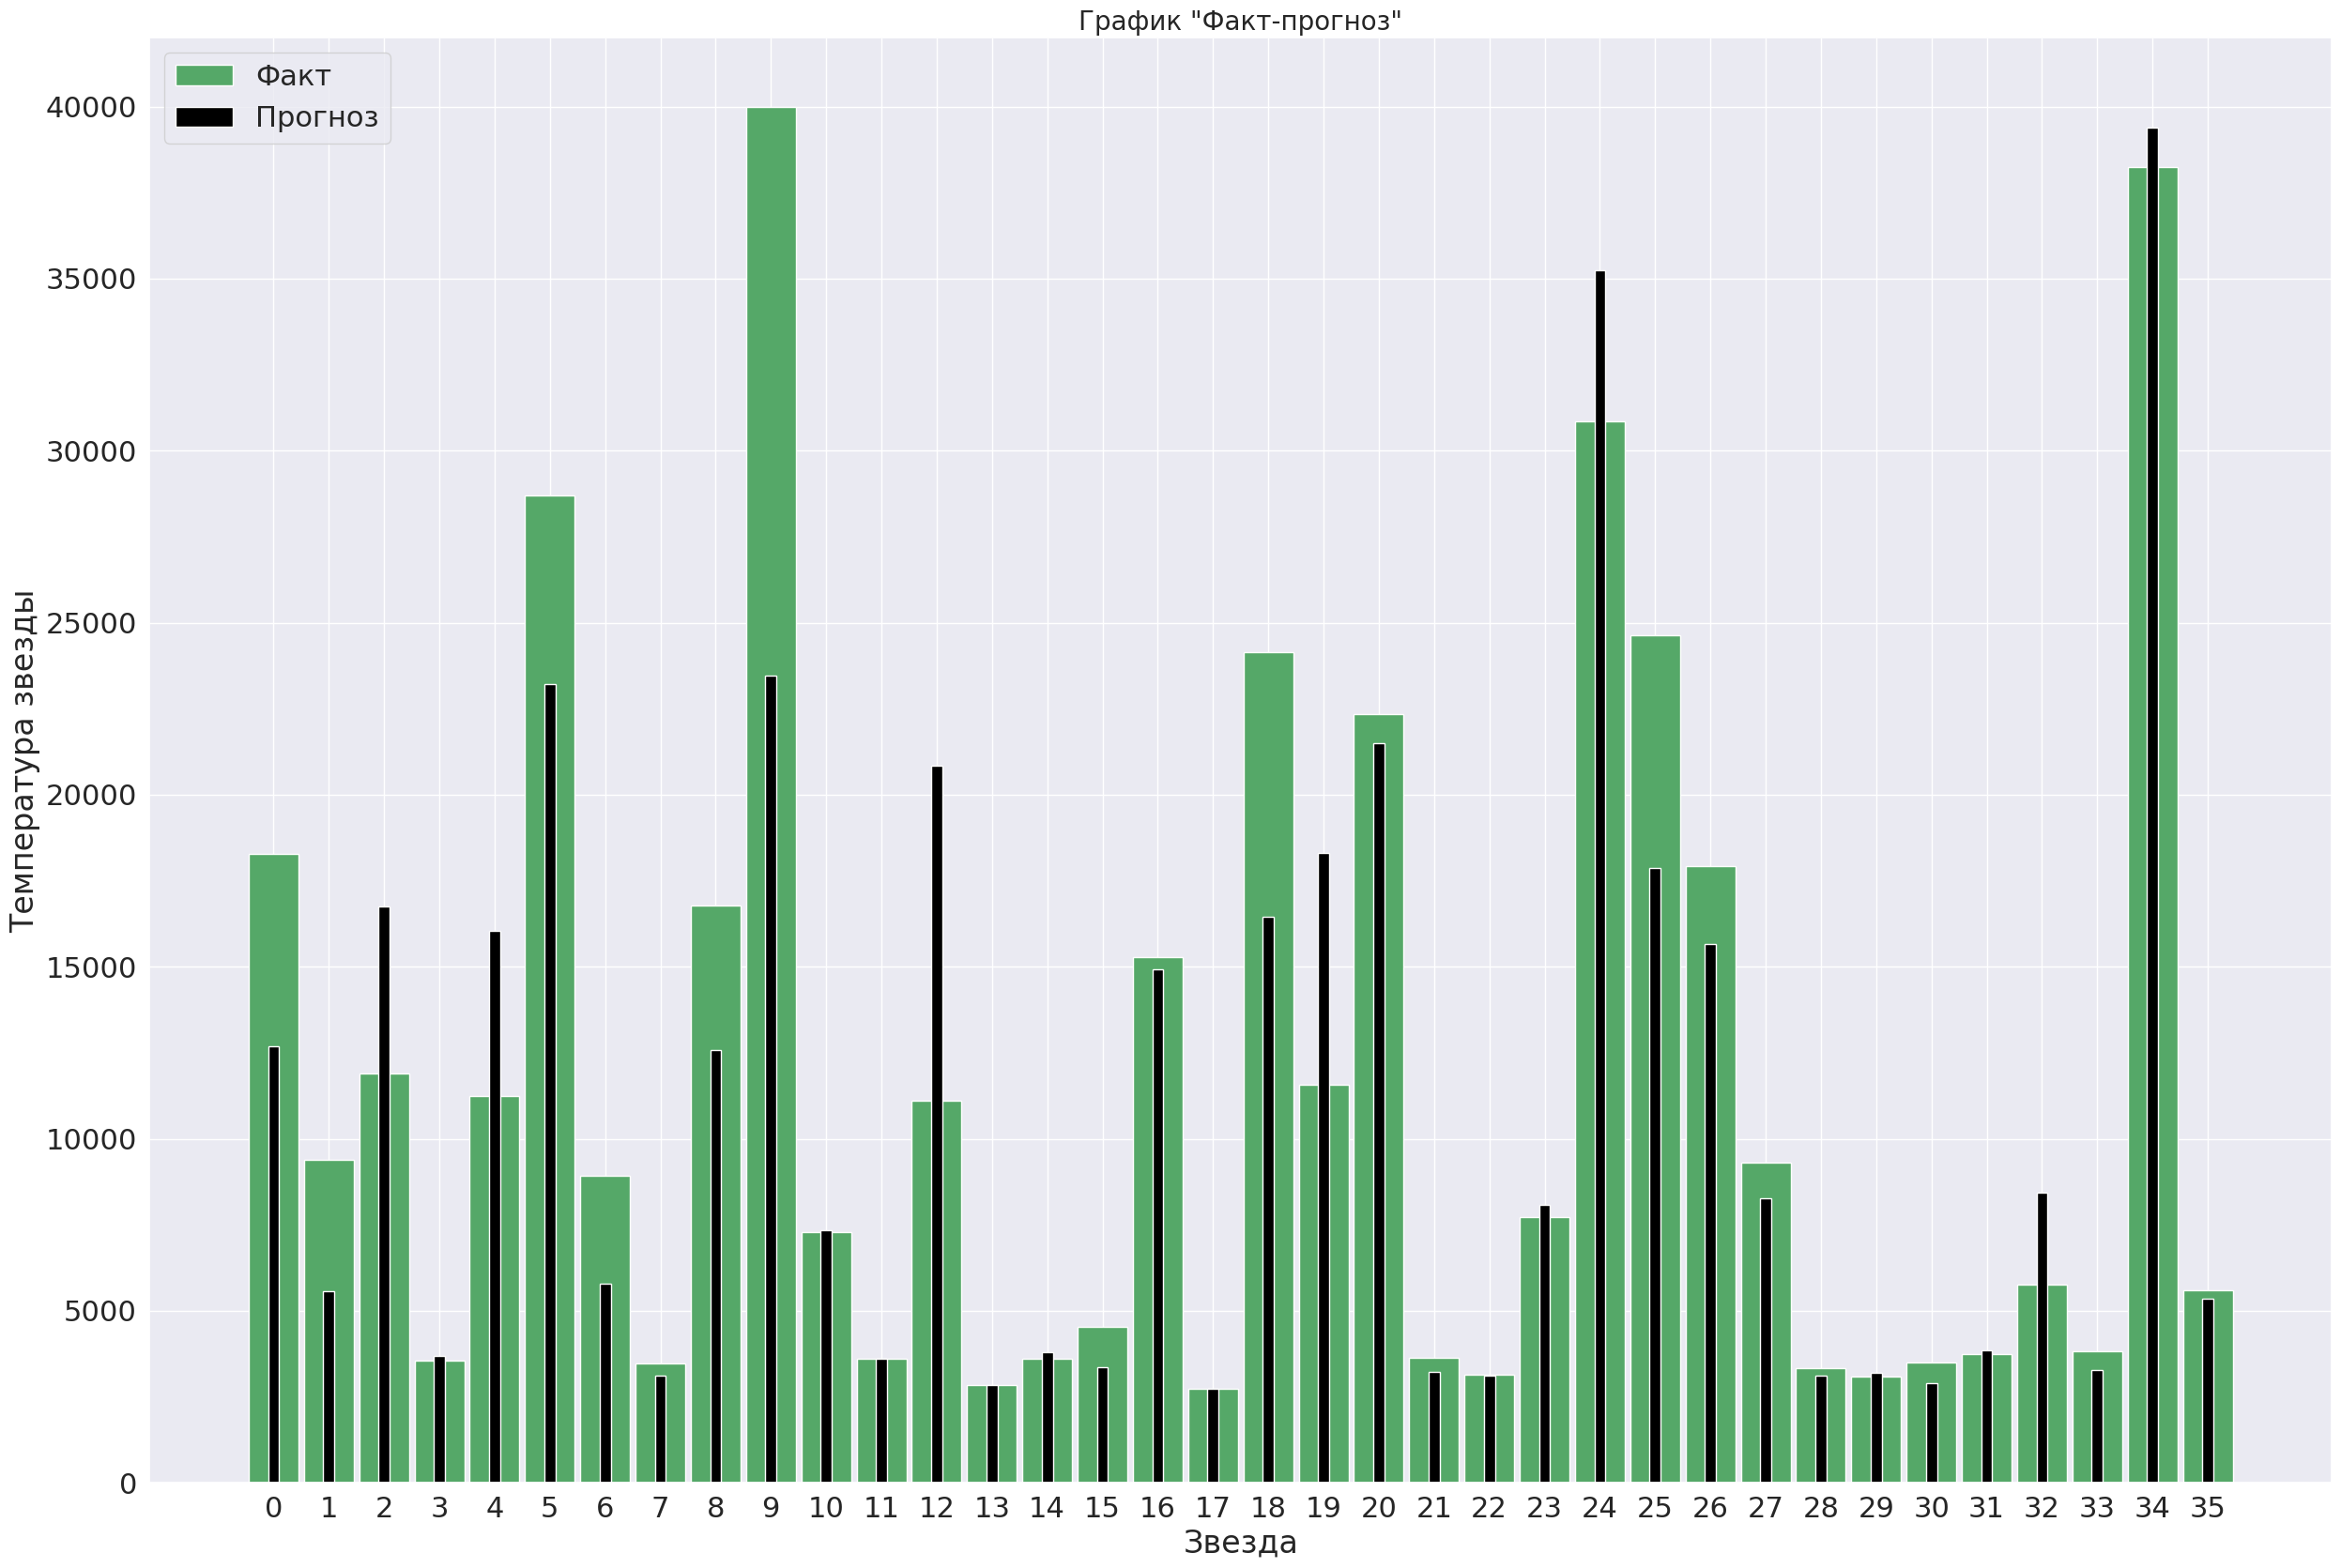

In [49]:
fact_forecast(test_preds_batch_norm, target_test)

Метрика `RMSE` на тесте получилась хуже - **4428.2251**. Но всё расно в пределах допустимого значения в **4500**.

**Создание, обучение и предсказания на модели с `DropOut`.**

Ниже будет создан список с параметрами dropout, перебор этих параметров, выбор лучшей модели и проверка на тестовой выборке.

In [50]:
# список значений dropout
dropout_lst = [0.1, 0.2, 0.3, 0.4, 0.5]

In [51]:
# начальное значение метрики для сравнения и выбора лучшей модели
best_rmse_valid = 10000
# переменная для лучшей модели
best_model_dropout = None
# переменная для лучшего параметра p_1
best_p_1 = 0
# переменная для лучшего параметра p_2
best_p_2 = 0

# перебор значений dropout для первого слоя
for p_1 in dropout_lst:
    # перебор значений dropout для второго слоя
    for p_2 in dropout_lst:
        # создание модели с выбранными p_1 и p_2
        model = create_model(n_neurons_2_hidden, drop=True, info=False, p_1=p_1, p_2=p_2)
        # модель и метрика на выходе
        model_dropout, rmse_valid_dropout = train_and_valid(model,
                                                            epochs,
                                                            loss_function,
                                                            features_train,
                                                            target_train,
                                                            features_valid,
                                                            target_valid,
                                                            rate=0.001,
                                                            batch_size=24,
                                                            epoch_step=100)
        # выбор лучшей модели, метрики на валидации и параметров dropout
        if rmse_valid_dropout < best_rmse_valid:
            best_rmse_valid = rmse_valid_dropout
            best_model_dropout = model_dropout
            best_p_1 = p_1
            best_p_2 = p_2


Идет обучение модели....
Обучается модель:  Sequential(
  (0): Linear(in_features=17, out_features=34, bias=True)
  (1): Dropout(p=0.1, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=34, out_features=17, bias=True)
  (4): Dropout(p=0.1, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=17, out_features=1, bias=True)
  (7): ReLU()
) 
Learning rate ---> 0.001 
Размер батча --> 24 
Шаг между эпохами на валидации --> 100 


Ранняя остановка!
Эпоха №  2200 
RMSE модели на валидации после ранней остановки:  3140.358642578125

Модель обучена!

Идет обучение модели....
Обучается модель:  Sequential(
  (0): Linear(in_features=17, out_features=34, bias=True)
  (1): Dropout(p=0.2, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=34, out_features=17, bias=True)
  (4): Dropout(p=0.1, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=17, out_features=1, bias=True)
  (7): ReLU()
) 
Learning rate ---> 0.001 
Размер батча --> 24 
Шаг между эпохами на валидации --> 100 


Ранняя

In [52]:
print('Лучшая модель с dropout:\n', best_model_dropout)
print()
print('Лучшая метрика RMSE на валидации -------------->', best_rmse_valid )
print()
print('Лучший коэффициент dropout для 1-го слоя ------>', best_p_1)
print()
print('Лучший коэффициент dropout для 2-го слоя ------>', best_p_2)
print()

Лучшая модель с dropout:
 Sequential(
  (0): Linear(in_features=17, out_features=34, bias=True)
  (1): Dropout(p=0.1, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=34, out_features=17, bias=True)
  (4): Dropout(p=0.1, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=17, out_features=1, bias=True)
  (7): ReLU()
)

Лучшая метрика RMSE на валидации --------------> 3140.358642578125

Лучший коэффициент dropout для 1-го слоя ------> 0.1

Лучший коэффициент dropout для 2-го слоя ------> 0.1



In [53]:
rmse_test_dropout, test_preds_dropout = test(best_model_dropout, features_test,
                                             target_test)

print(
    f'Метрика RMSE на тестовой выборке для лучшей модели испосльзуя DropOut ------------>',
    round(rmse_test_dropout, 4))

Метрика RMSE на тестовой выборке для лучшей модели испосльзуя DropOut ------------> 3400.9312


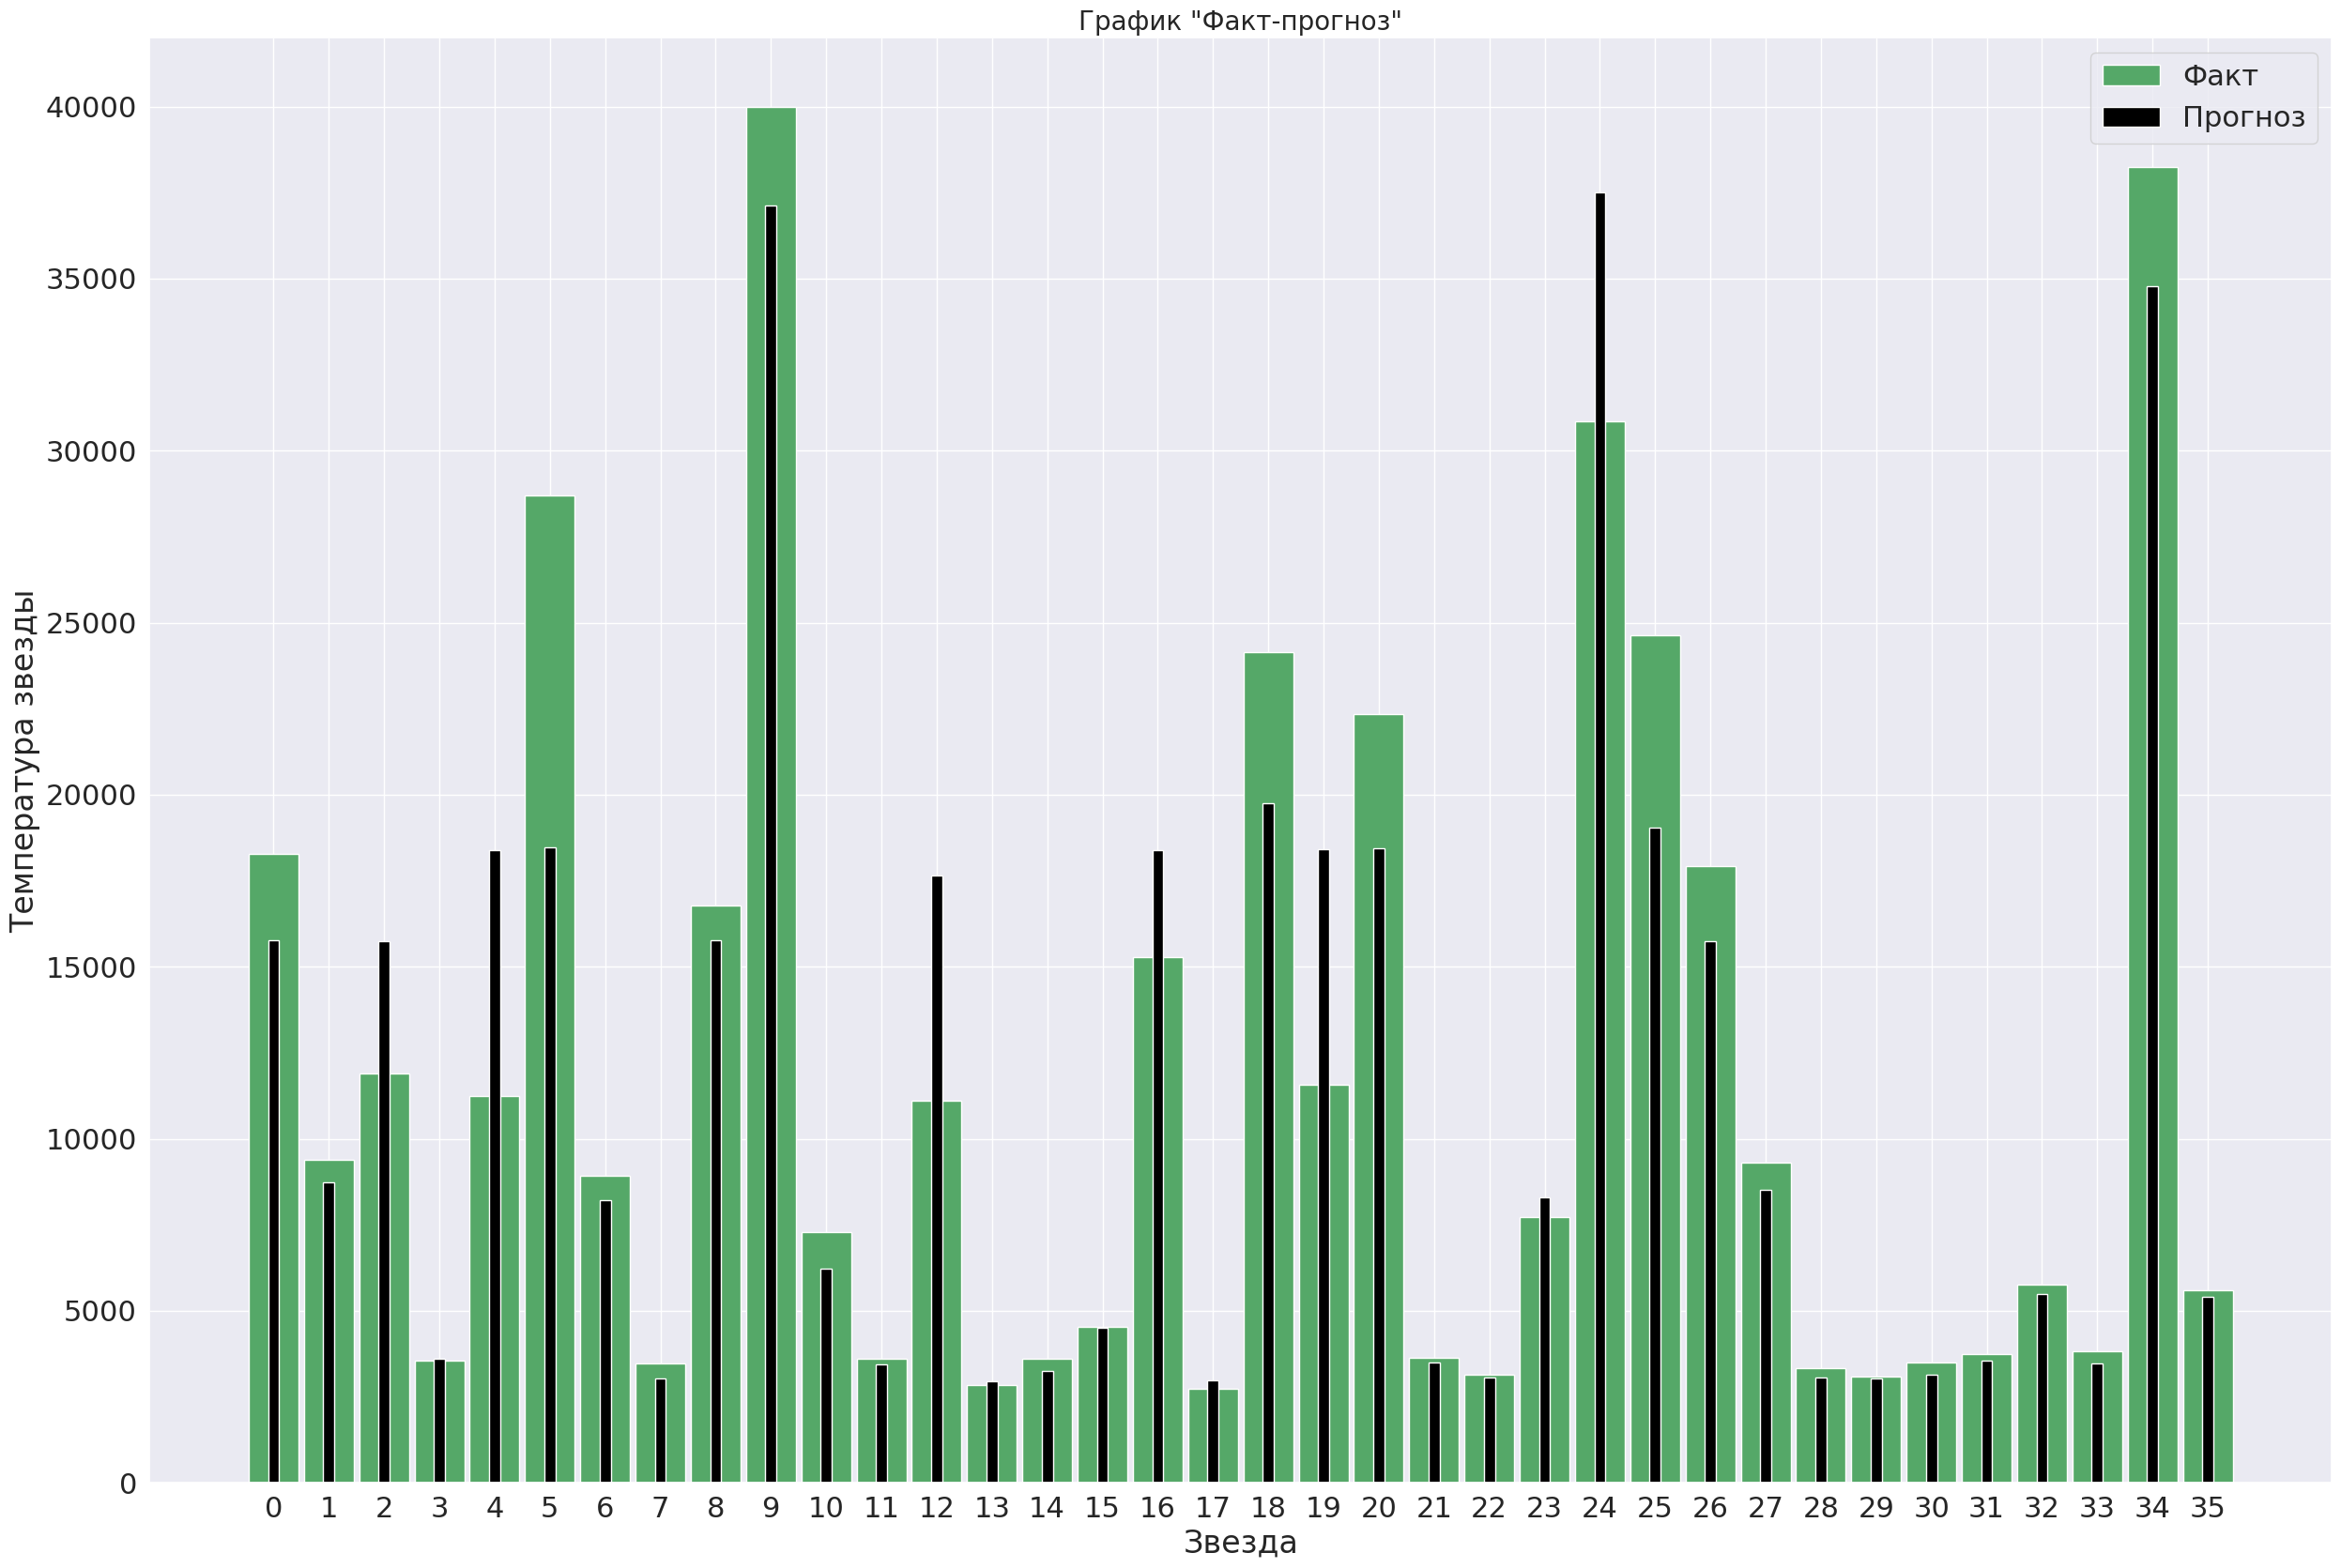

In [54]:
fact_forecast(test_preds_dropout, target_test)

Удалось чуть чуть улучшить метрику до **3400.9312**

**Результирующая таблица по метрикам.**

In [55]:
data_res = {
    'RMSE лучшей модели на тестовой выборке':
    round(rmse_test, 4),
    'RMSE лучшей модели на тестовой выборке + BatchNorm':
    round(rmse_test_bath_norm, 4),
    'RMSE лучшей модели на тестовой выборке + DropOut':
    round(rmse_test_dropout, 4)
}

data_result = pd.DataFrame(
    data_res,
    index=[
        'Модель: 2 скрытых слоя, 17 входных нейронов, 34 и 17 нейронов в скрытых слоях, 1 нейрон на выходе'
    ])
data_result

,RMSE лучшей модели на тестовой выборке,RMSE лучшей модели на тестовой выборке + BatchNorm,RMSE лучшей модели на тестовой выборке + DropOut
"Модель: 2 скрытых слоя, 17 входных нейронов, 34 и 17 нейронов в скрытых слоях, 1 нейрон на выходе",3402.606,4428.2251,3400.9312


**Финальная визуализация.**

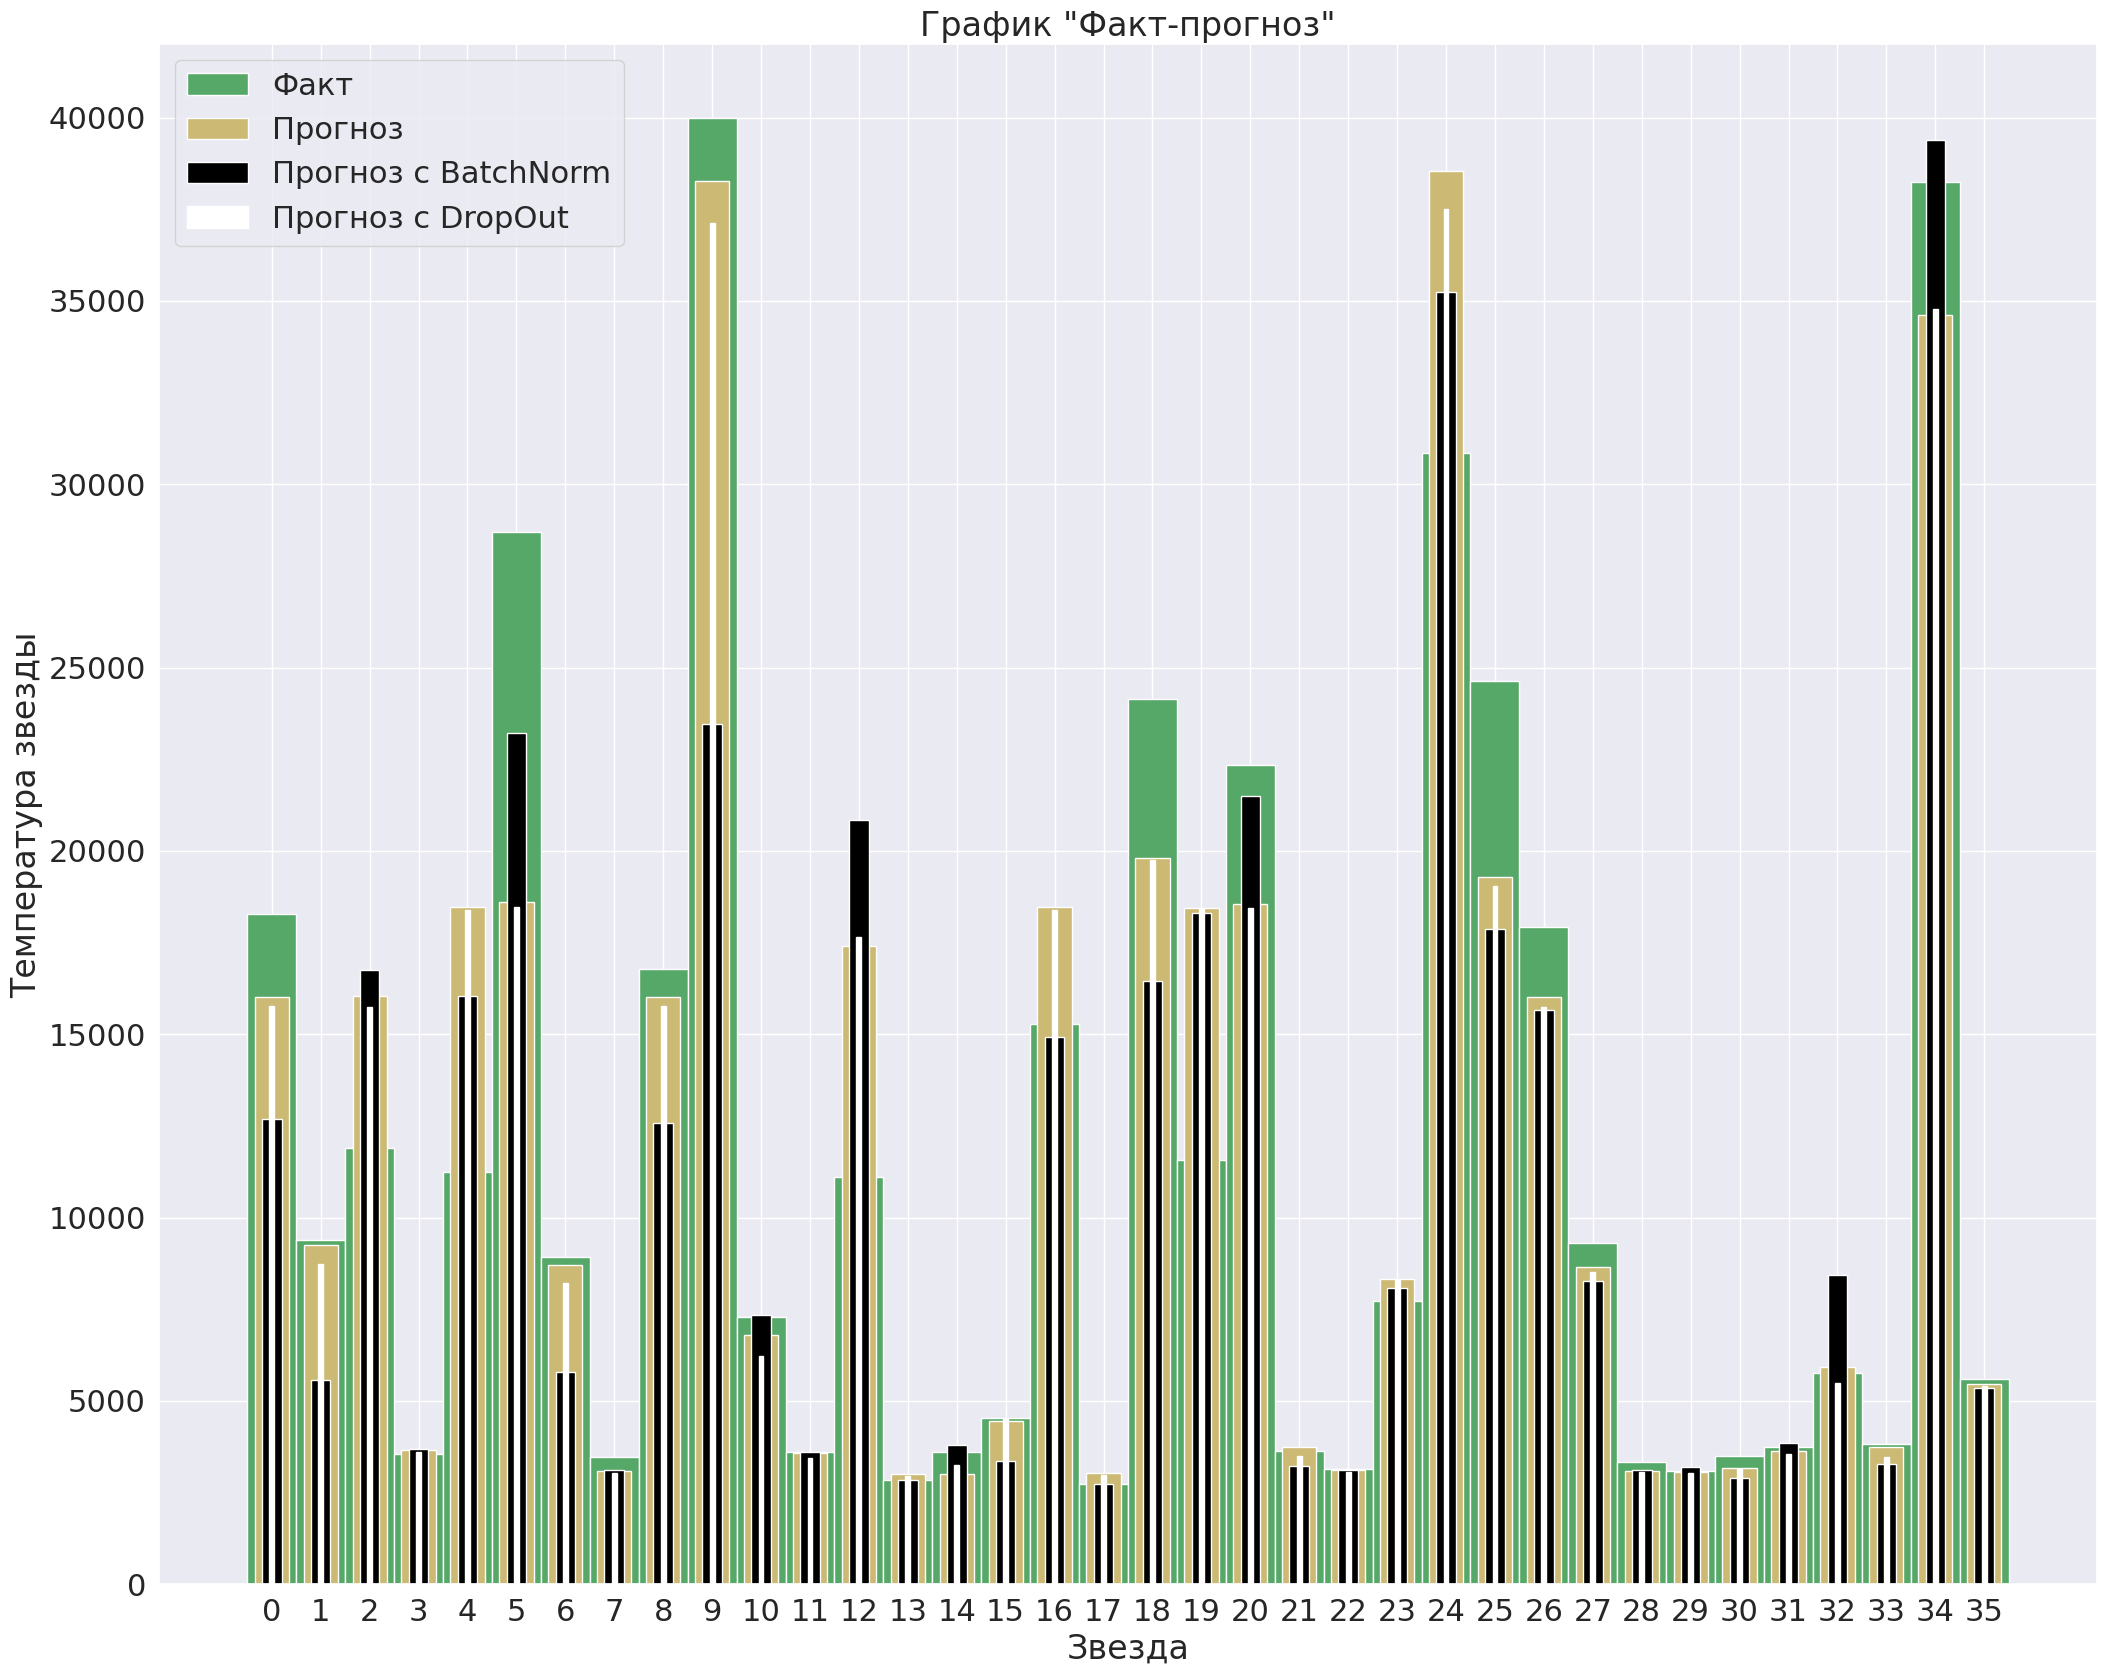

In [56]:
real = target_test.detach().numpy().reshape([-1])
preds = test_preds.detach().numpy().reshape([-1])
preds_batch = test_preds_batch_norm.detach().numpy().reshape([-1])
preds_drop = test_preds_dropout.detach().numpy().reshape([-1])
x = np.arange(len(real))

fig, ax = plt.subplots()
fig.set_figwidth(25)
fig.set_figheight(20)

ax.set_xticks(x)

fact = ax.bar(x, real, width=1, label='Факт', color='g')
forecast = ax.bar(x, preds, width=0.7, label='Прогноз', color='y')
forecast_batch = ax.bar(x,
                        preds_batch,
                        width=0.4,
                        label='Прогноз с BatchNorm',
                        color='black')
forecast_drop = ax.bar(x,
                       preds_drop,
                       width=0.1,
                       label='Прогноз с DropOut',
                       color='w')

ax.legend()
ax.set_title('График "Факт-прогноз"')
ax.set_xlabel('Звезда')
ax.set_ylabel('Температура звезды')
plt.show()

Как видно из суммарного графика, модель практически идеально предсказывает температуру звёзд менее 5000 К.

Существенные ошибки появляются у звезд более 10000 К - например звезда номер 12, номер 5б номер 24.

`BatchNorm1d` ухудшил предсказания. 

`DropOut` чуть-чуть улучшил....

## Вывод


В результате иссследования были обработаны данные, улучшена классификация звезд по истинному цвету.

Построена базовая модель нейронной сети со следующими параметрами:

 полносвязанная нейронная сеть,
- количество входных нейронов: **17**
- нейроны первого слоя: **34**,
- нейроны второго слоя: **17**,
- **1** выходной нейрон,
- оптимизатор `Adam`,
- коэффициент сходимости: **0.001**,
- размер батча: **24**.

Метрика **RMSE - 3402.606** на базовой модели, что существенно лучше заявленного порока в **4500**.


`BatchNorm1d` ухудшил предсказания до **4428.2251**. 

`DropOut` чуть-чуть улучшил до **3400.9312**.


Т.к. разница в улучшенной модели небольшая, то можно использовать как базовую модель, так и с `DropOut`.